# Crypto EDA

## Packages

In [53]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import r2_score
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

import xgboost as xgb

## Crypto data range

### Start Date & Days

In [5]:
directory = "crypto_csv/"

cryptos = []

for name in os.listdir(directory):
    df = pd.read_csv(directory+name,index_col=False)
    df["date"] = pd.to_datetime(df.date)
    
    if "exchangeVolume(USD)" in df.columns:
        mask = df["exchangeVolume(USD)"]>0
        cryptos.append((name,str(min(df.date).date()),len(df.date),len(df[mask].date)))
    else:
        cryptos.append((name,str(min(df.date).date()),len(df.date)))
    
cryptos.sort(key=lambda x: x[2])

cryptos

[('btg.csv', '2017-11-16', 137, 137),
 ('icx.csv', '2017-10-30', 154, 154),
 ('rhoc.csv', '2017-10-09', 175, 175),
 ('ada.csv', '2017-10-04', 180, 180),
 ('salt.csv', '2017-10-02', 182, 182),
 ('knc.csv', '2017-09-27', 187, 187),
 ('trx.csv', '2017-09-16', 198, 198),
 ('wtc.csv', '2017-08-30', 215, 215),
 ('ven.csv', '2017-08-25', 220, 217),
 ('zrx.csv', '2017-08-19', 226, 226),
 ('btm.csv', '2017-08-11', 234, 234),
 ('bch.csv', '2017-08-03', 242, 242),
 ('bnb.csv', '2017-07-28', 248, 248),
 ('ethos.csv', '2017-07-21', 255, 255),
 ('cvc.csv', '2017-07-20', 256, 256),
 ('omg.csv', '2017-07-17', 259, 259),
 ('ppt.csv', '2017-07-14', 262, 262),
 ('mtl.csv', '2017-07-12', 264, 264),
 ('gas.csv', '2017-07-09', 267, 267),
 ('eos.csv', '2017-07-04', 272, 272),
 ('snt.csv', '2017-07-01', 275, 275),
 ('pay.csv', '2017-06-30', 276, 276),
 ('fun.csv', '2017-06-30', 276, 276),
 ('veri.csv', '2017-06-11', 295, 295),
 ('bat.csv', '2017-06-04', 302, 302),
 ('ae.csv', '2017-06-04', 302, 302),
 ('ant.c

In [6]:
df_temp = pd.read_csv("crypto_csv/trend_blockchain.csv", index_col = False)
df_temp.head(10)

date       val
0  2014-01-05  0.390863
1  2014-01-06  0.497462
2  2014-01-07  0.446701
3  2014-01-08  0.411168
4  2014-01-09  0.456853
5  2014-01-10  0.507614
6  2014-01-11  0.289340
7  2014-01-12  0.424191
8  2014-01-13  0.470187
9  2014-01-14  0.511073

## BTC EDA

### Data Load

In [7]:
def load_econ_data(index, dir_path="crypto_csv/" ):
    df = pd.read_csv(dir_path+index+".csv",index_col=False)
    df.columns = [x.replace("(USD)","").lower() for x in df.columns]
    
    df["date"]=pd.to_datetime(df.date,yearfirst=True)
    df.set_index("date",drop=True,inplace=True)

    df.columns = [index+"_"+x for x in df.columns]

    return df

def load_crypto_data(symbol, dir_path = "crypto_csv/",
                     features = ['price_close', 'fees', 'txcount', 'tx_unit', 'ex_unit']):

    df = pd.read_csv(dir_path+symbol+".csv",index_col=False)
    df.columns = [x.replace("(USD)","").lower() for x in df.columns]
        
    df.drop(columns=["activeaddresses","marketcap","generatedcoins"], inplace=True)
    
    # Rename prices
    df.rename({"price":"price_open", "txvolume":"tx_dollar", "exchangevolume":"ex_dollar"},axis="columns",inplace=True)
    df["price_close"] = df.price_open.shift(-1)

    # Change volume from dollar to unit volume
    df["tx_unit"] = df.tx_dollar / ((df.price_open + df.price_close)/2)
    df["ex_unit"] = df.ex_dollar / ((df.price_open + df.price_close)/2)
    
    # Set date index
    df["date"]=pd.to_datetime(df.date,yearfirst=True)
    df.set_index("date",drop=True,inplace=True,)
    
    df = df[features]
    
    df.columns = [symbol+"_"+x for x in df.columns]
    
    return df
    

In [59]:
df_btc = load_crypto_data("btc")
df_ltc = load_crypto_data("ltc")
df_xrp = load_crypto_data("xrp")
df_xmr = load_crypto_data("xmr")
df_dash = load_crypto_data("dash")

indices = ['sp500','gold','liborusd','trend_bitcoin','trend_blockchain']
econ_dfs = []
for i in indices:
    econ_dfs.append(load_econ_data(i))

#df_data = pd.concat([df_btc]+econ_dfs, axis=1)
df_data = pd.concat([df_btc,
                     df_ltc.ltc_price_close,
                     df_xrp.xrp_price_close,
                     df_xmr.xmr_price_close,
                     df_dash.dash_price_close]+econ_dfs, axis=1)

df_data.dropna(inplace=True)

features_price = ['btc_price_close']
features_btc = ['btc_fees', 'btc_txcount', 'btc_tx_unit','btc_ex_unit']
features_alt = ['ltc_price_close', 'xrp_price_close', 'xmr_price_close','dash_price_close']
features_ext = ['dash_price_close', 'sp500_value', 'gold_value', 'liborusd_value','trend_bitcoin_val', 'trend_blockchain_val']
features_all = features_btc+features_alt+features_ext

features_sets = [features_price + f for f in [features_btc,features_alt,features_ext,features_all]]


In [9]:
df_data.tail()

btc_price_close   btc_fees  btc_txcount    btc_tx_unit  \
date                                                                 
2018-03-19          8619.67  30.780649     191373.0  633308.890095   
2018-03-20          8937.48  31.379079     195041.0  574464.053402   
2018-03-21          8939.44  31.025274     194694.0  673501.340658   
2018-03-22          8736.25  27.724789     185044.0  583454.053966   
2018-03-23          8901.95  26.257673     179685.0  585693.947225   

              btc_ex_unit  ltc_price_close  xrp_price_close  xmr_price_close  \
date                                                                           
2018-03-19  793349.835149           161.52         0.736759           217.94   
2018-03-20  724695.067252           169.56         0.713055           224.26   
2018-03-21  676081.785900           168.72         0.693145           218.56   
2018-03-22  625762.275758           163.58         0.663111           212.47   
2018-03-23  675139.186538           168.53         0.646214           215.37   

            dash_price_close  sp500_value  gold_value  liborusd_value  \
date                                                                    
2018-03-19            412.49    2725.7075    1314.575        1.845883   
2018-03-20            429.15    2716.9400    1312.750        1.853820   
2018-03-21            434.44    2711.9300    1316.350        1.861250   
2018-03-22            411.27    2643.6900    1328.850        1.871500   
2018-03-23            432.18    2588.2600    1342.350        1.875000   

            trend_bitcoin_val  trend_blockchain_val  
date                                                 
2018-03-19           2.896552              7.557627  
2018-03-20           2.719212              7.806780  
2018-03-21           2.541872              7.640678  
2018-03-22           2.512315              8.305085  
2018-03-23           2.334975              7.474576

### Plots (Values)

In [10]:
def plot_series(series, n=30, figsize=(15,4)):
    plt.figure(figsize=figsize)
    plt.plot(series)
    plt.plot(series.rolling(n).mean(),"r",label="rolling mean")
    plt.plot(series.rolling(n).std(),"orange", label="rolling std")
    plt.legend()
        
def plot_log10_diff(series, n=30, figsize=(15,4)):
    plot_series(series, n, figsize)
#    plot_series(series-series.shift(1), n, figsize)
#    plot_series(np.log10(series), n, figsize)
    plot_series(np.log10(series)-np.log10(df.price.shift(1)))

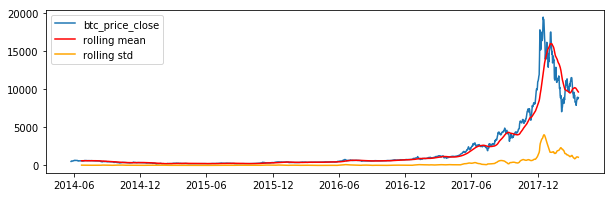

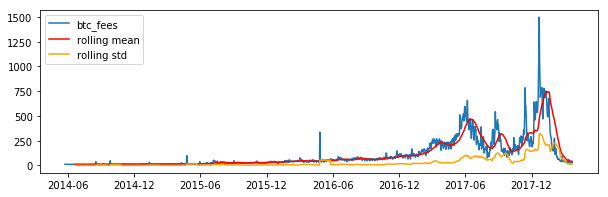

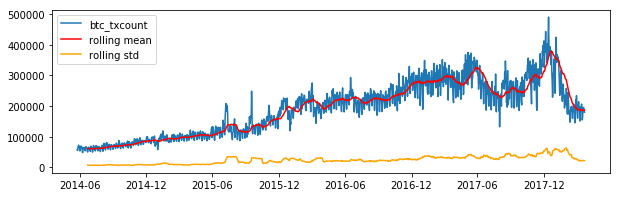

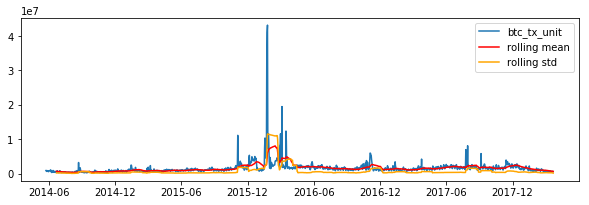

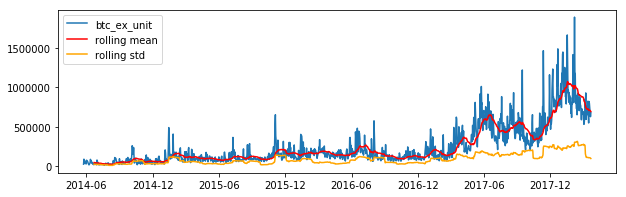

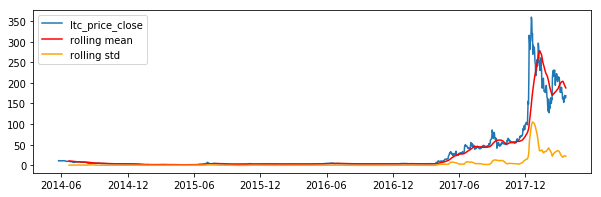

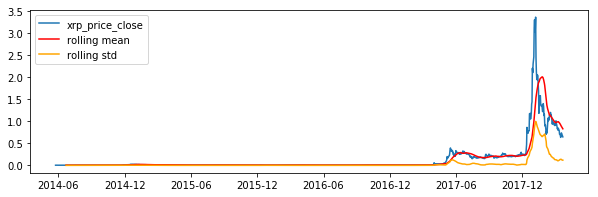

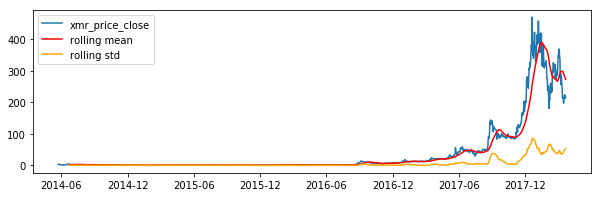

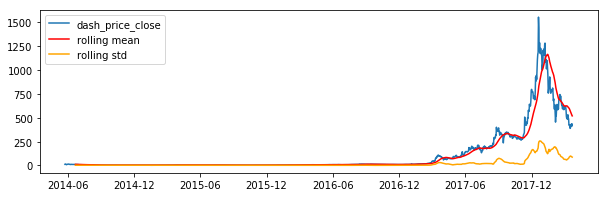

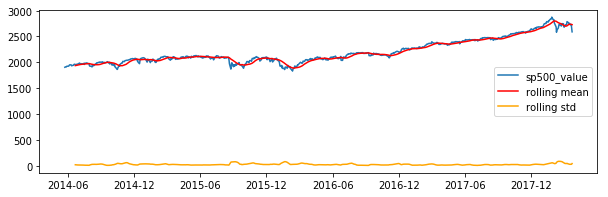

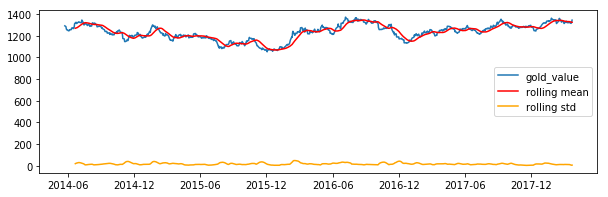

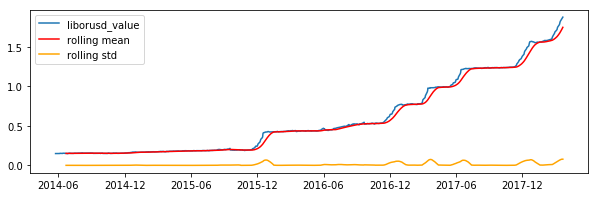

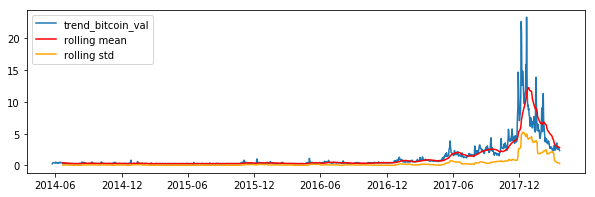

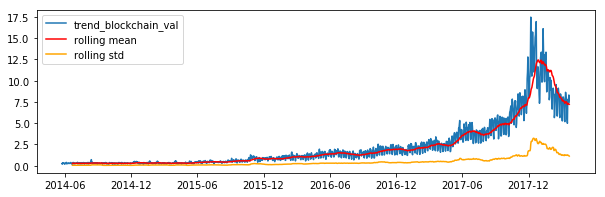

In [11]:
for f in df_data.columns:
    plot_series(df_data[f], figsize=(10,3))

### Plots (Returns)

In [12]:
def convert_daily_return(series):
    lag = series.shift(1)
    return (series - lag)/lag

def invert_daily_return(series,returns):
    lag = series.shift(1)
    return  (lag * returns) + lag

In [13]:
df_returns = df_data.apply(convert_daily_return).dropna()[1:]

df_returns.head()

btc_price_close  btc_fees  btc_txcount  btc_tx_unit  btc_ex_unit  \
date                                                                           
2014-05-26         0.019601  0.259014     0.192389    -0.128868    -0.394375   
2014-05-27        -0.018332  0.013807     0.058180     0.345190     0.268863   
2014-05-28         0.007728  0.098029     0.042485    -0.020704    -0.490057   
2014-05-29        -0.014141 -0.095675    -0.078284    -0.229333    -0.026970   
2014-05-30         0.083618 -0.033896    -0.002803     0.231792     0.652893   

            ltc_price_close  xrp_price_close  xmr_price_close  \
date                                                            
2014-05-26        -0.002591         0.025354        -0.059006   
2014-05-27        -0.033766         0.238766        -0.260726   
2014-05-28        -0.013441         0.079202        -0.013393   
2014-05-29        -0.020890        -0.051909        -0.239819   
2014-05-30         0.044527        -0.112230        -0.059524   

            dash_price_close  sp500_value  gold_value  liborusd_value  \
date                                                                    
2014-05-26         -0.249667     0.001492   -0.001748        0.000000   
2014-05-27         -0.060337     0.001490   -0.001751        0.000000   
2014-05-28         -0.323890    -0.001114   -0.013835       -0.003322   
2014-05-29          0.310056     0.005367   -0.008892        0.006667   
2014-05-30          0.182303     0.001844    0.000000        0.000000   

            trend_bitcoin_val  trend_blockchain_val  
date                                                 
2014-05-26           0.164706              0.918367  
2014-05-27           0.000000              0.063830  
2014-05-28          -0.030303             -0.060000  
2014-05-29           0.010417             -0.159574  
2014-05-30           0.030928              0.037975

(array([  3.,   8.,  33., 152., 886., 259.,  43.,   9.,   3.,   2.]),
 array([-0.20987985, -0.16384572, -0.11781159, -0.07177745, -0.02574332,
         0.02029081,  0.06632494,  0.11235908,  0.15839321,  0.20442734,
         0.25046148]),
 <a list of 10 Patch objects>)

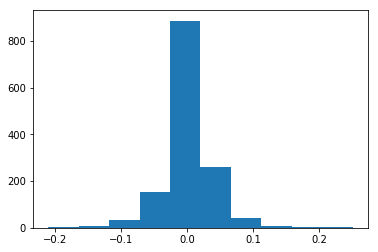

In [14]:
plt.hist(df_returns.btc_price_close)

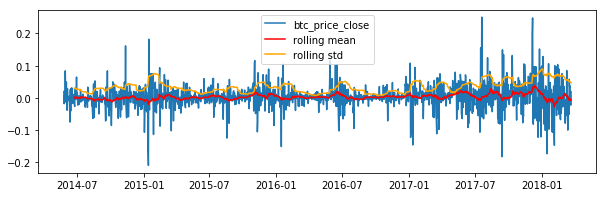

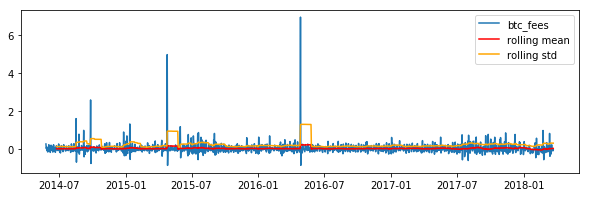

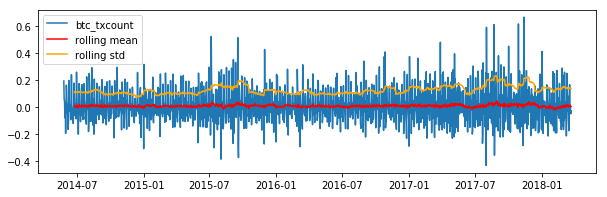

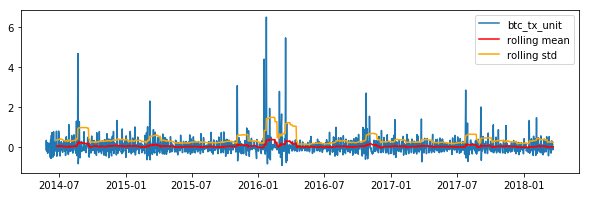

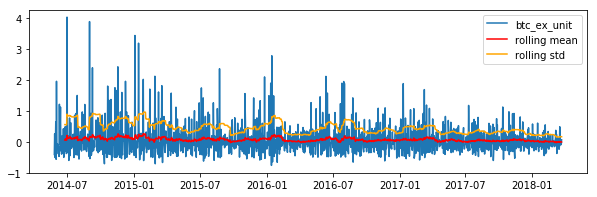

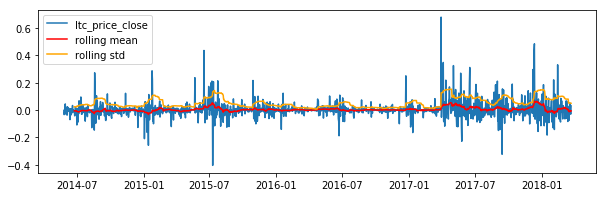

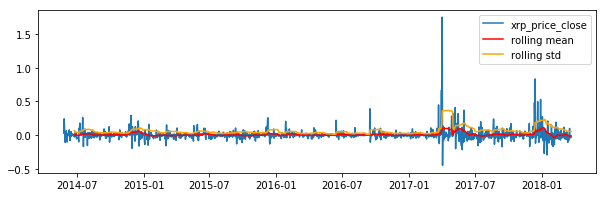

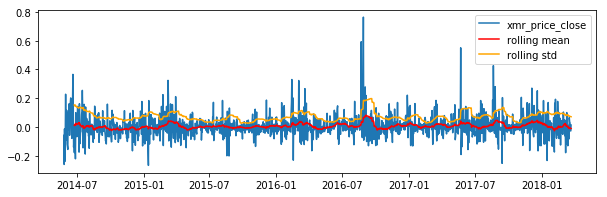

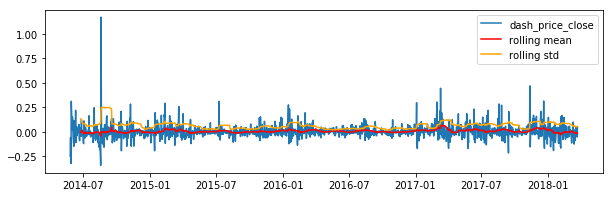

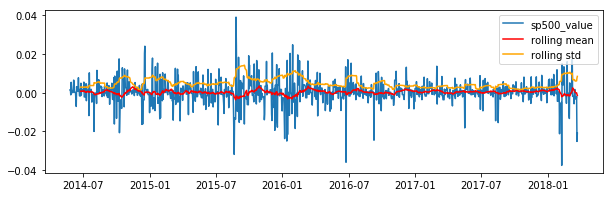

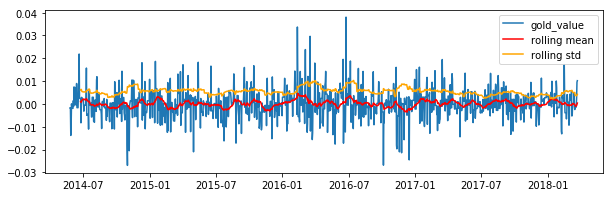

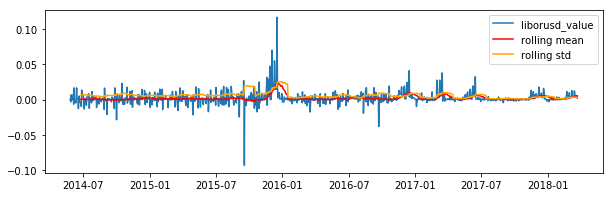

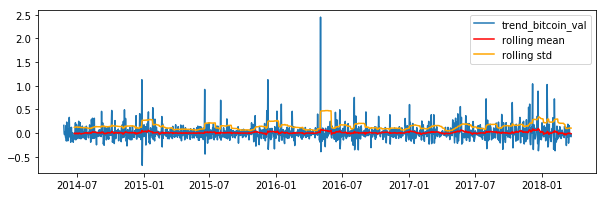

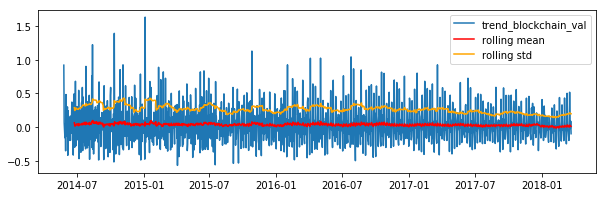

In [15]:
for f in df_returns.columns:
    plot_series(df_returns[f], figsize=(10,3))

### Correlations

In [16]:
df_returns_next = df_returns.shift(-1)
df_returns_next.columns = ["next_"+name for name in df_returns_next.columns]
df_temp = pd.concat([df_returns,df_returns_next],axis=1)

df_temp.dropna().head()

btc_price_close  btc_fees  btc_txcount  btc_tx_unit  btc_ex_unit  \
date                                                                           
2014-05-26         0.019601  0.259014     0.192389    -0.128868    -0.394375   
2014-05-27        -0.018332  0.013807     0.058180     0.345190     0.268863   
2014-05-28         0.007728  0.098029     0.042485    -0.020704    -0.490057   
2014-05-29        -0.014141 -0.095675    -0.078284    -0.229333    -0.026970   
2014-05-30         0.083618 -0.033896    -0.002803     0.231792     0.652893   

            ltc_price_close  xrp_price_close  xmr_price_close  \
date                                                            
2014-05-26        -0.002591         0.025354        -0.059006   
2014-05-27        -0.033766         0.238766        -0.260726   
2014-05-28        -0.013441         0.079202        -0.013393   
2014-05-29        -0.020890        -0.051909        -0.239819   
2014-05-30         0.044527        -0.112230        -0.059524   

            dash_price_close  sp500_value            ...              \
date                                                 ...               
2014-05-26         -0.249667     0.001492            ...               
2014-05-27         -0.060337     0.001490            ...               
2014-05-28         -0.323890    -0.001114            ...               
2014-05-29          0.310056     0.005367            ...               
2014-05-30          0.182303     0.001844            ...               

            next_btc_ex_unit  next_ltc_price_close  next_xrp_price_close  \
date                                                                       
2014-05-26          0.268863             -0.033766              0.238766   
2014-05-27         -0.490057             -0.013441              0.079202   
2014-05-28         -0.026970             -0.020890             -0.051909   
2014-05-29          0.652893              0.044527             -0.112230   
2014-05-30         -0.548842             -0.029307             -0.020558   

            next_xmr_price_close  next_dash_price_close  next_sp500_value  \
date                                                                        
2014-05-26             -0.260726              -0.060337          0.001490   
2014-05-27             -0.013393              -0.323890         -0.001114   
2014-05-28             -0.239819               0.310056          0.005367   
2014-05-29             -0.059524               0.182303          0.001844   
2014-05-30              0.227848               0.013526          0.000087   

            next_gold_value  next_liborusd_value  next_trend_bitcoin_val  \
date                                                                       
2014-05-26        -0.001751             0.000000                0.000000   
2014-05-27        -0.013835            -0.003322               -0.030303   
2014-05-28        -0.008892             0.006667                0.010417   
2014-05-29         0.000000             0.000000                0.030928   
2014-05-30        -0.001944            -0.000166               -0.090000   

            next_trend_blockchain_val  
date                                   
2014-05-26                   0.063830  
2014-05-27                  -0.060000  
2014-05-28                  -0.159574  
2014-05-29                   0.037975  
2014-05-30                  -0.353659  

[5 rows x 28 columns]

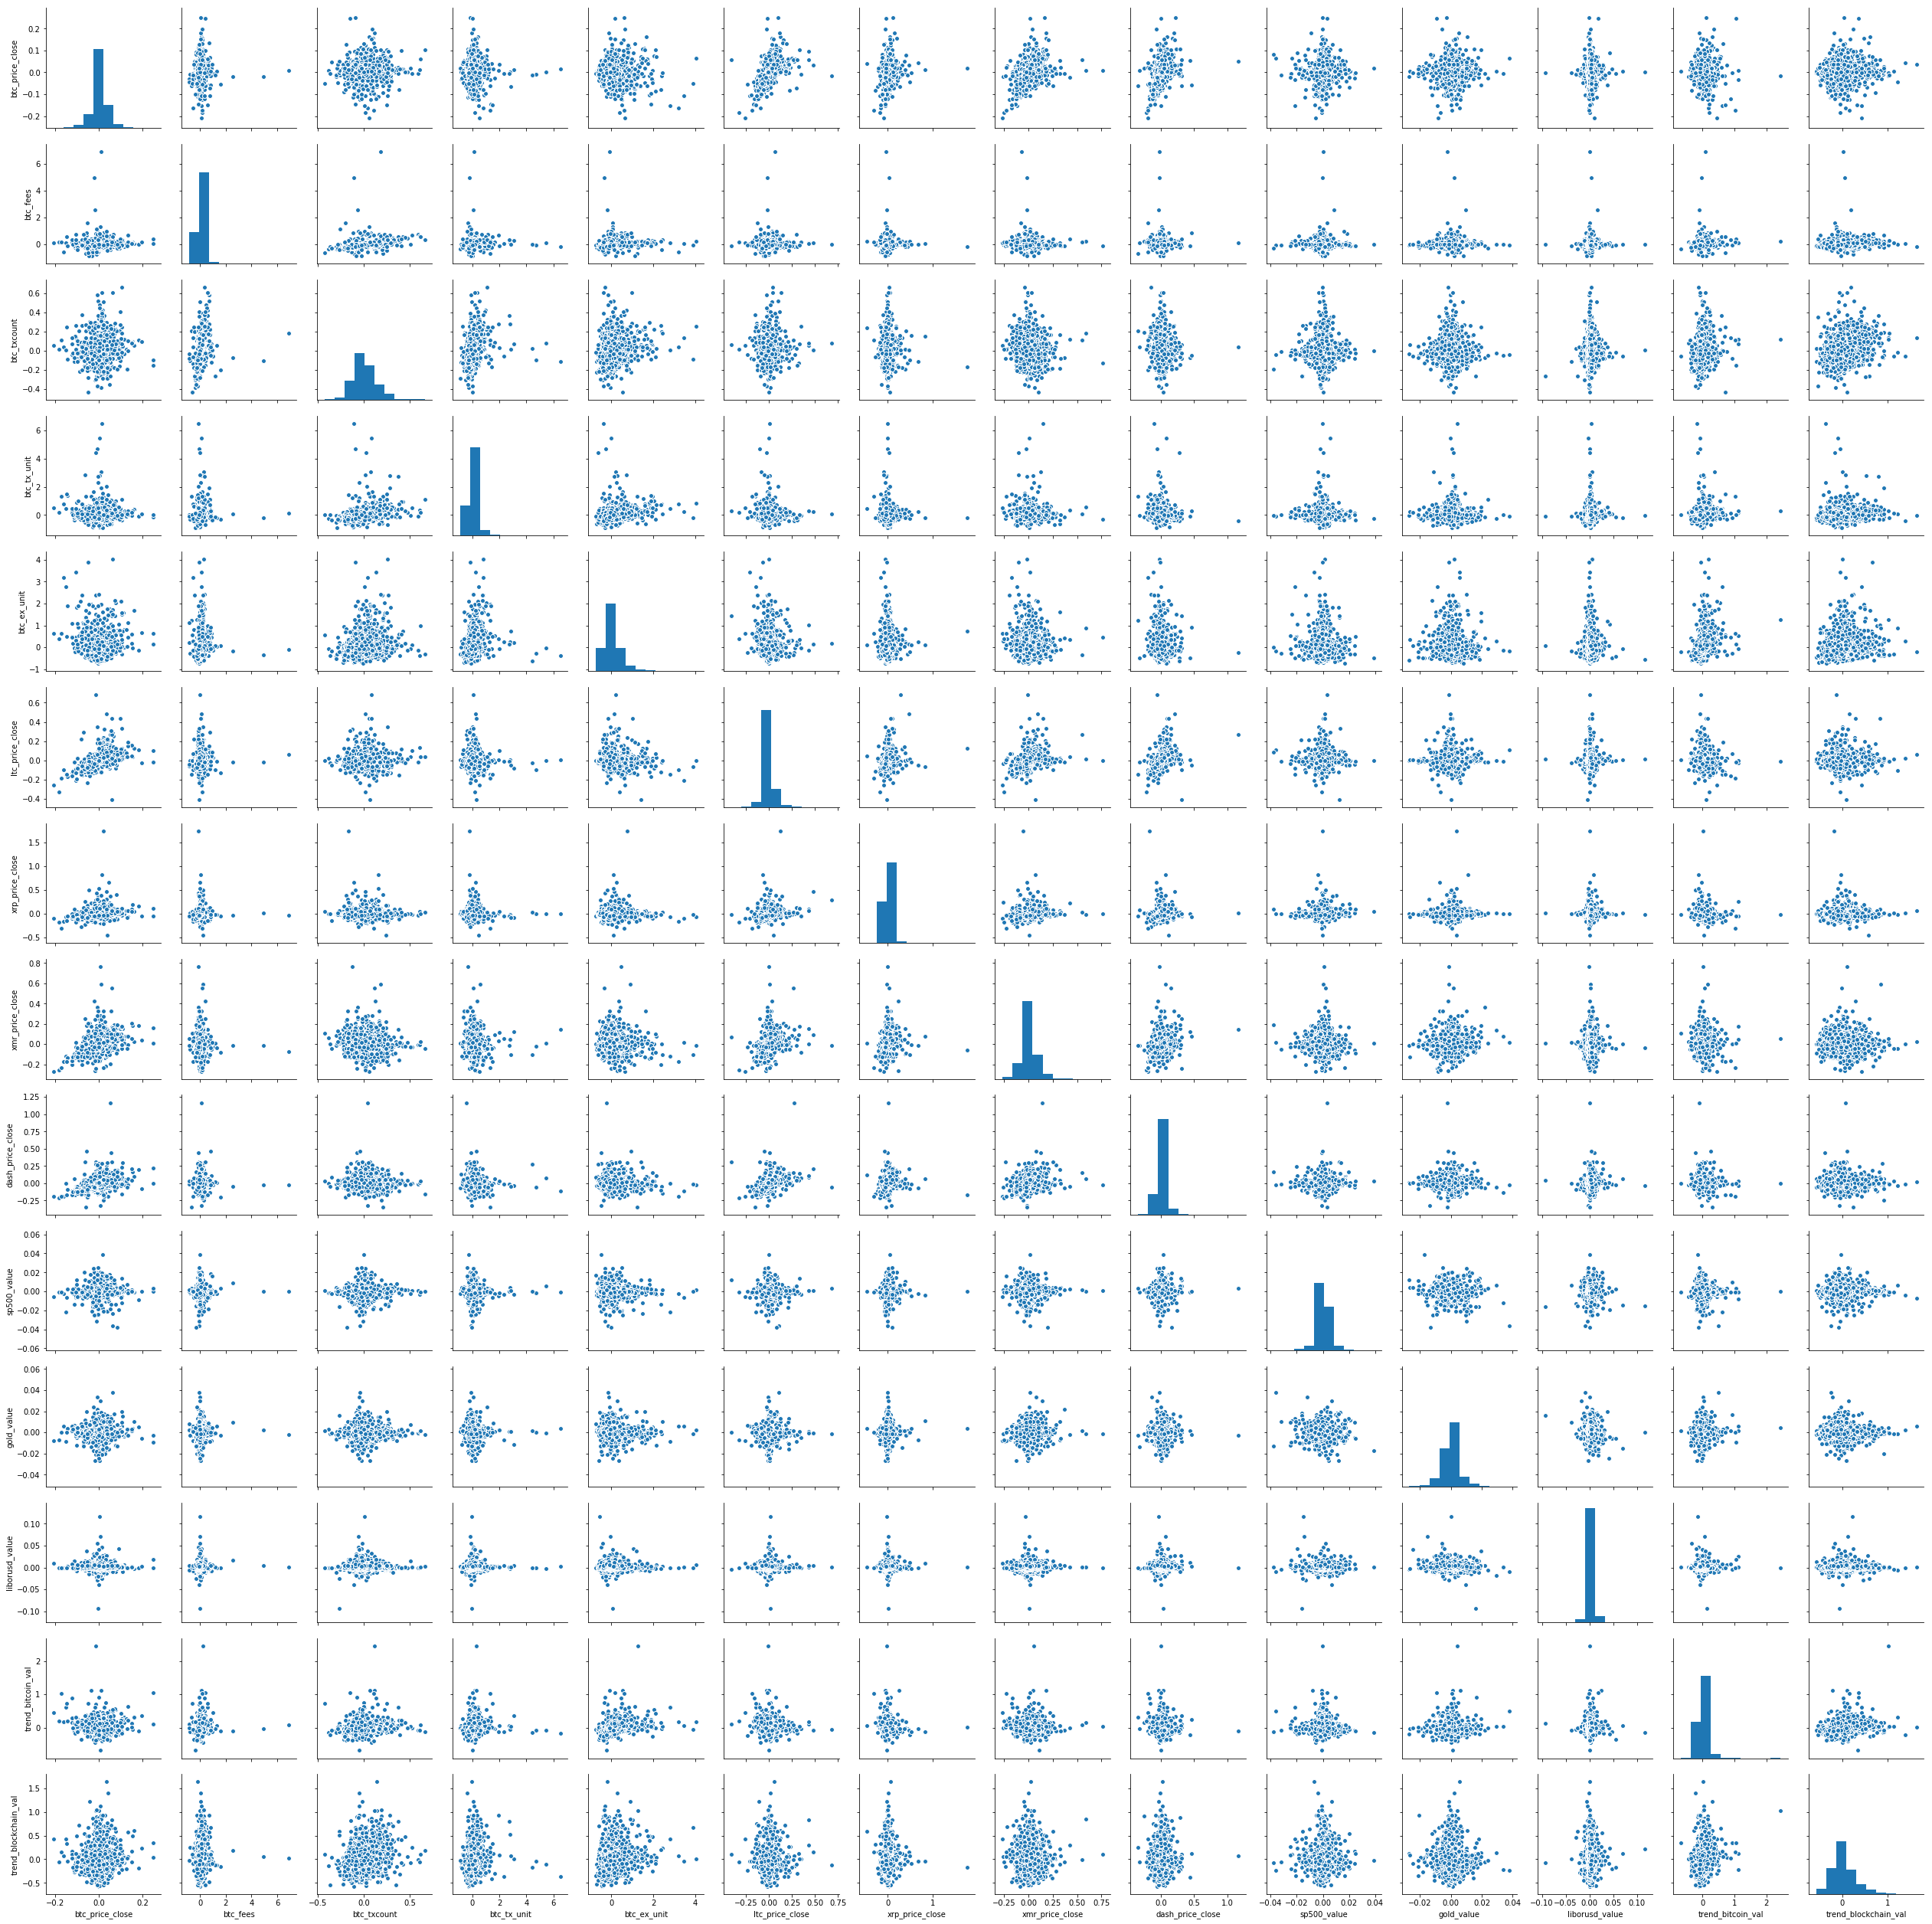

In [17]:
sns.pairplot(df_returns.dropna())

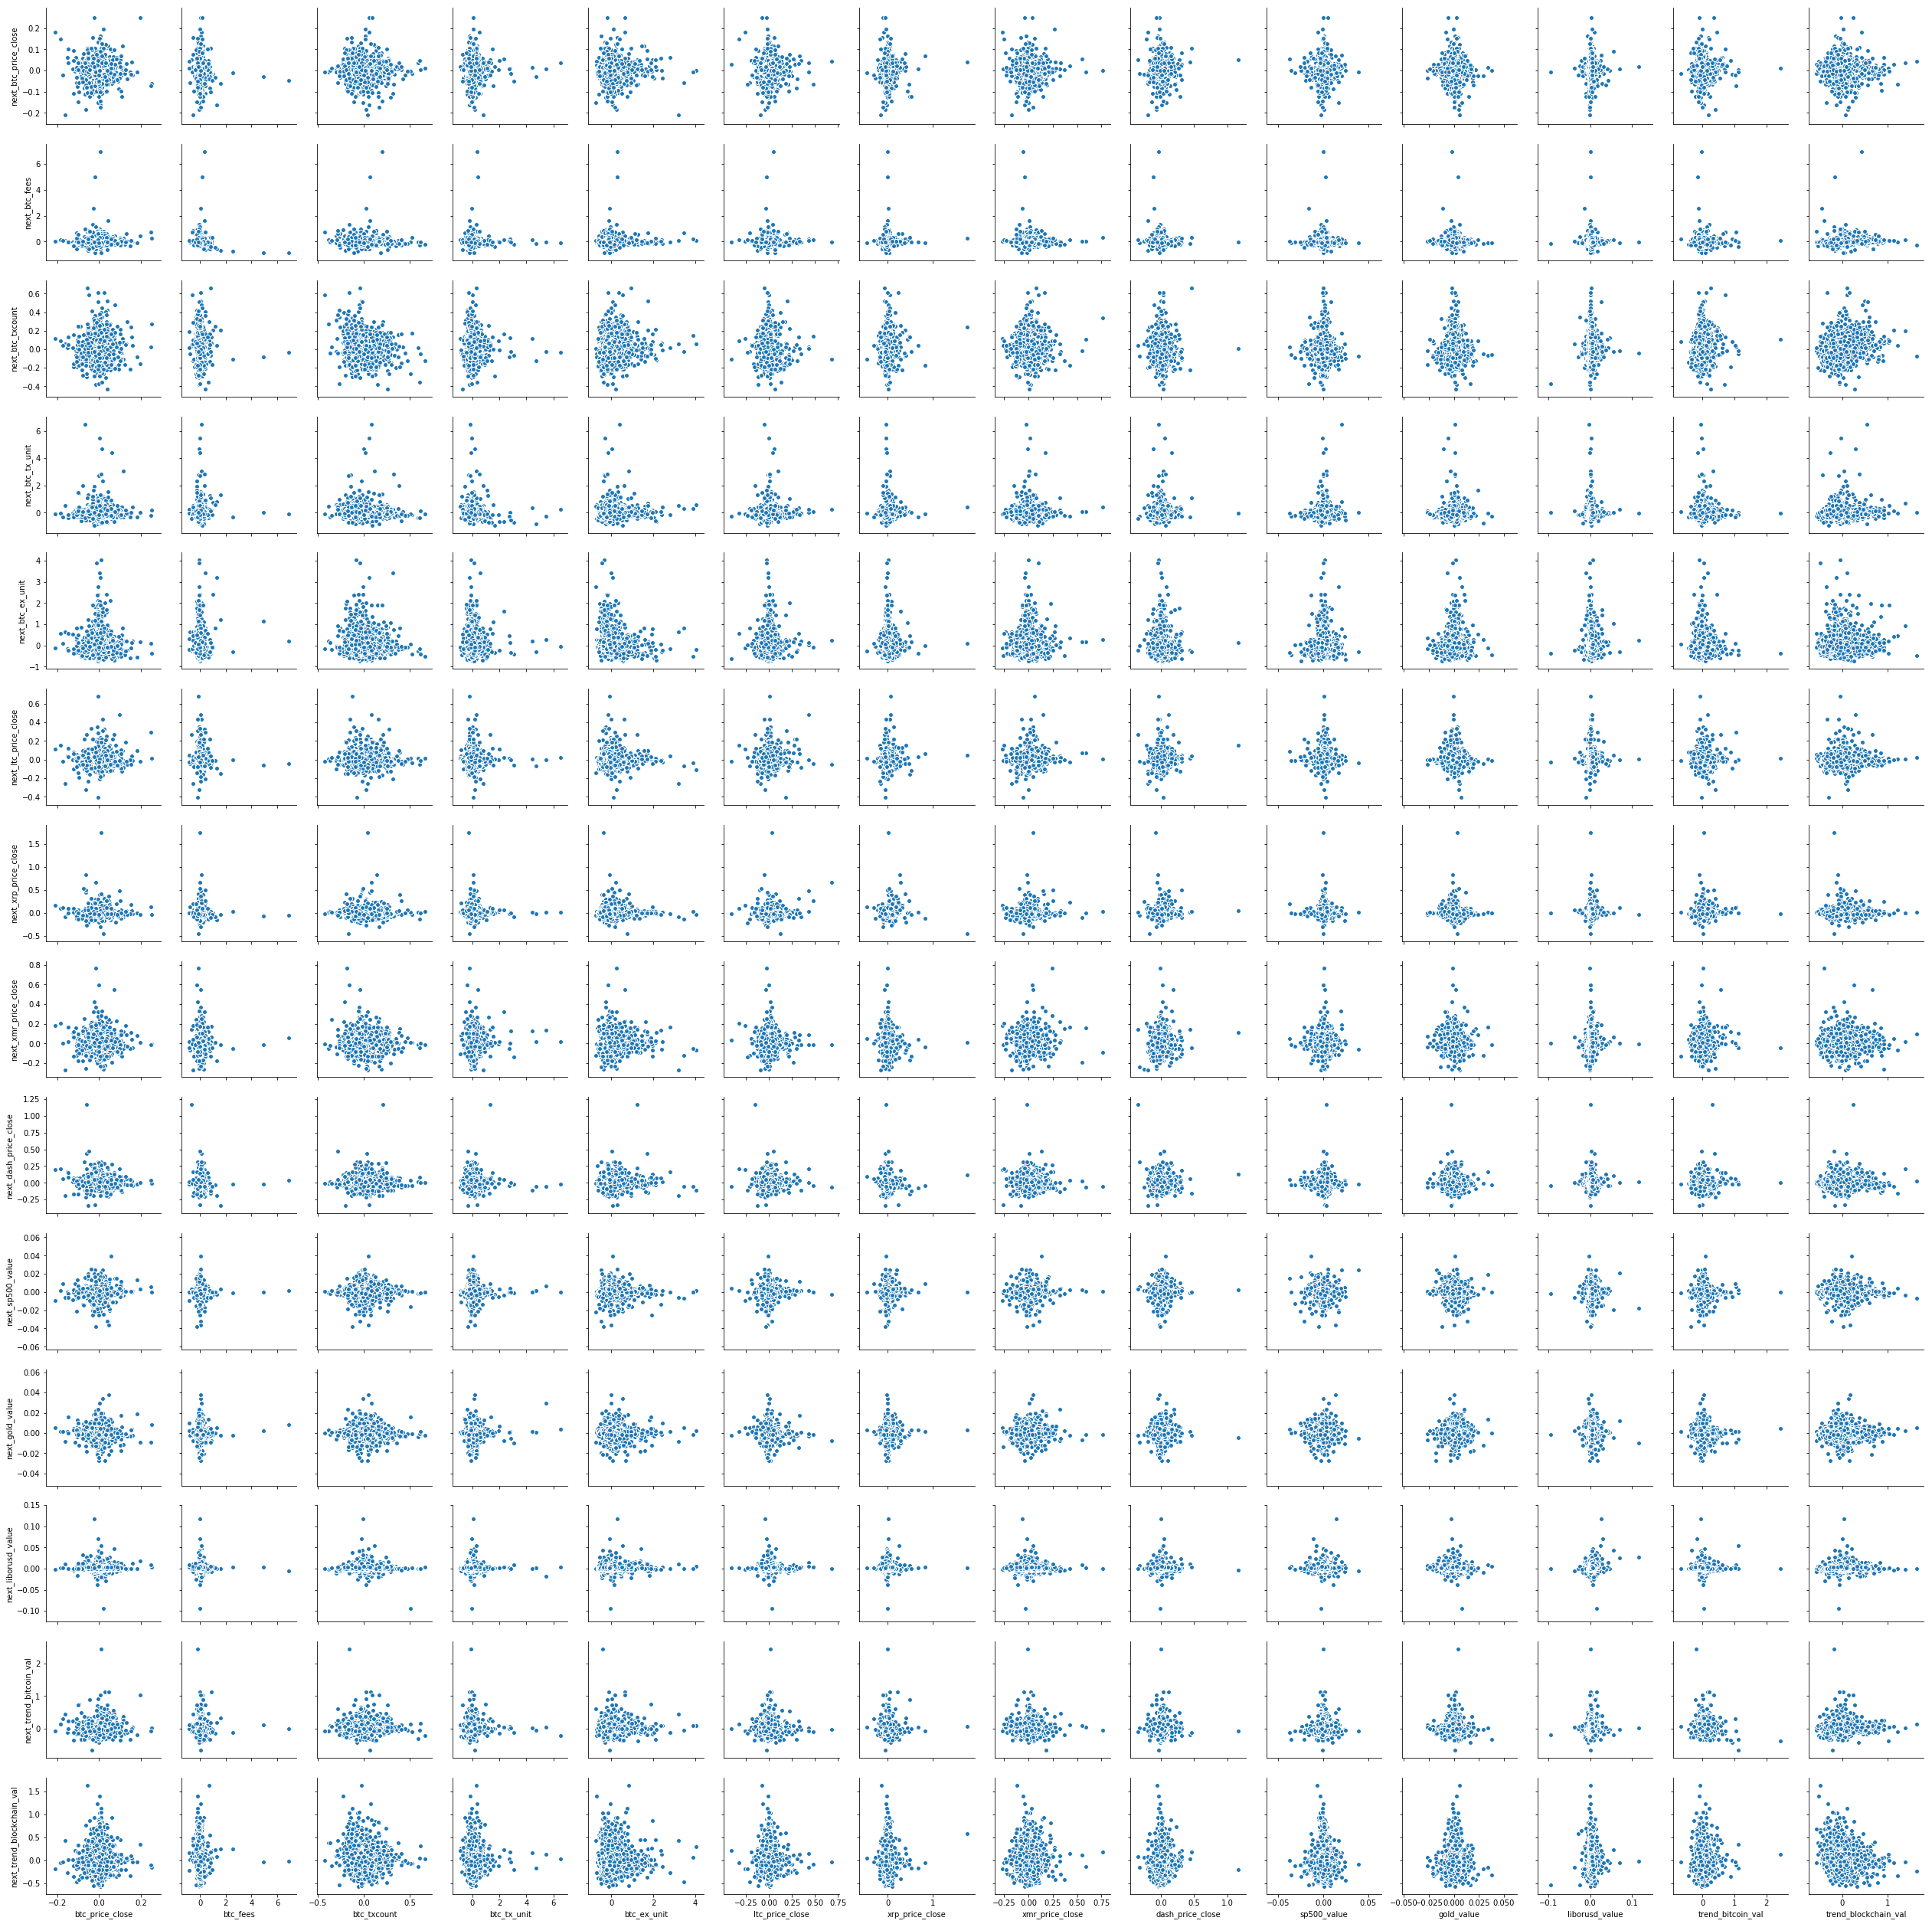

In [18]:
sns.pairplot(df_temp.dropna(),x_vars = df_returns.columns, y_vars = df_returns_next.columns)

btc_price_close 1398


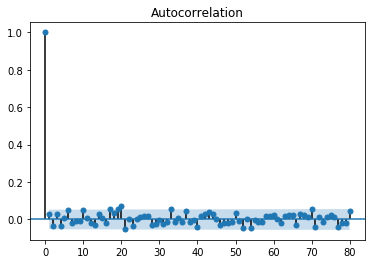

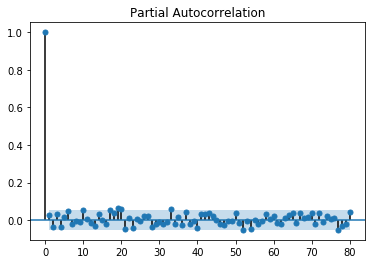


btc_fees 1398


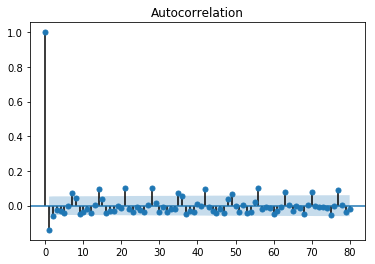

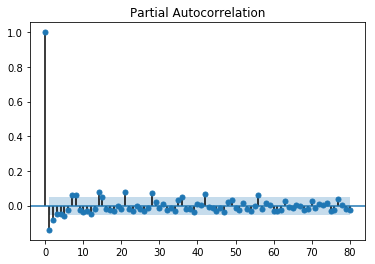


btc_txcount 1398


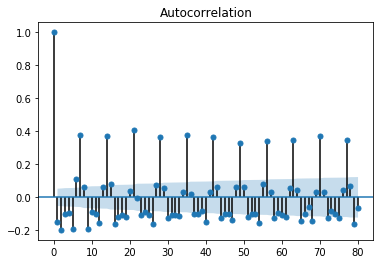

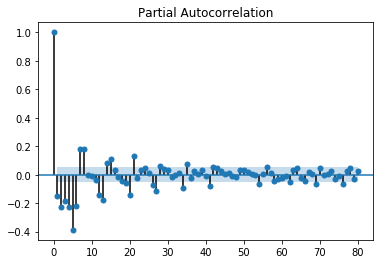


btc_tx_unit 1398


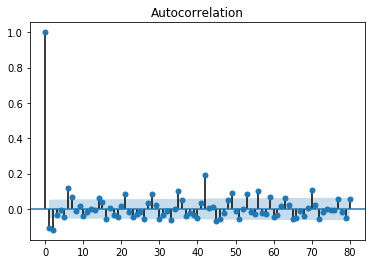

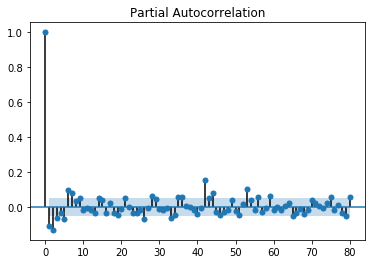


btc_ex_unit 1398


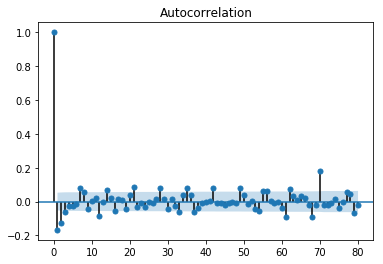

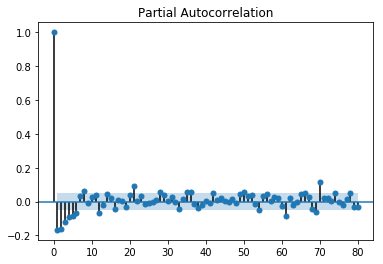


ltc_price_close 1398


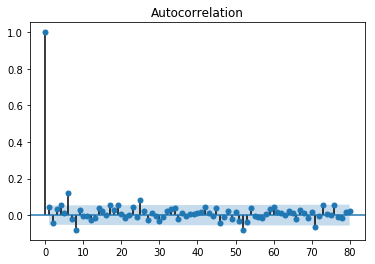

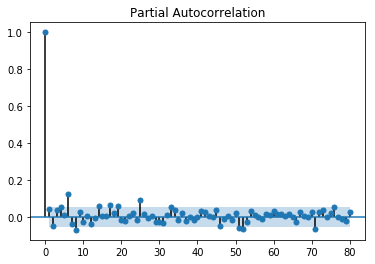


xrp_price_close 1398


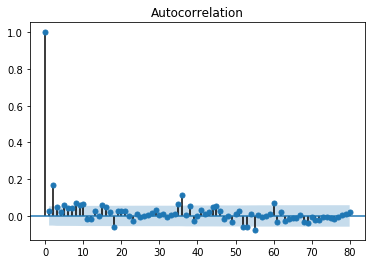

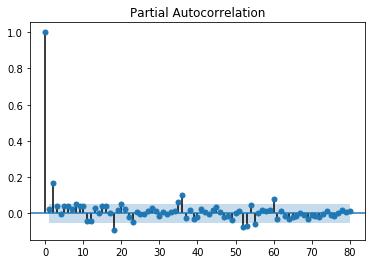


xmr_price_close 1398


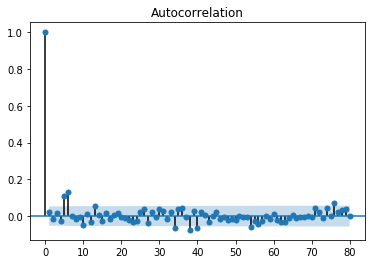

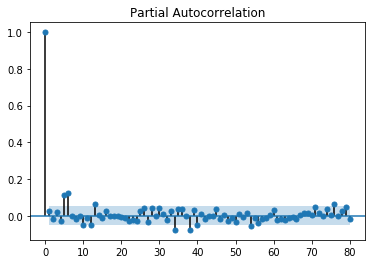


dash_price_close 1398


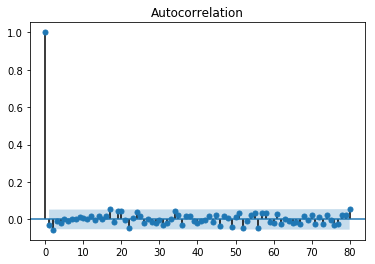

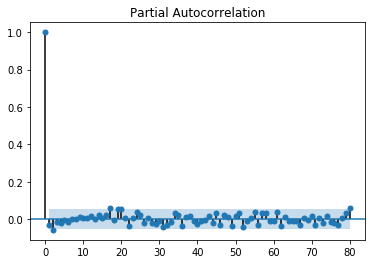


sp500_value 1398


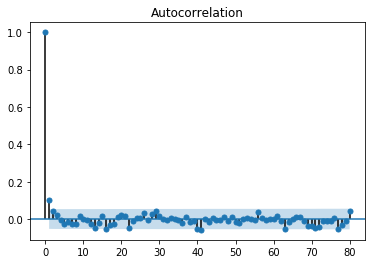

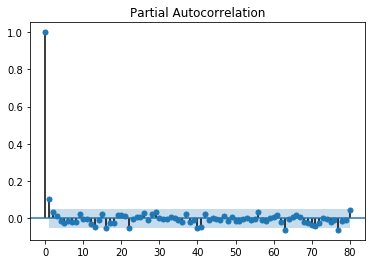


gold_value 1398


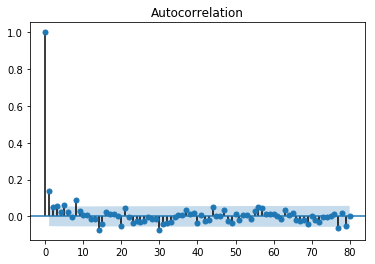

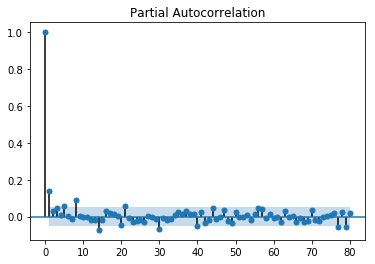


liborusd_value 1398


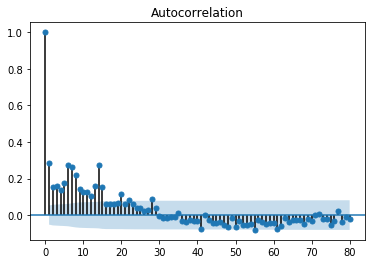

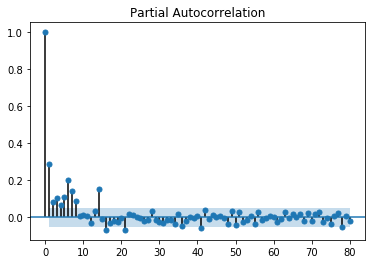


trend_bitcoin_val 1398


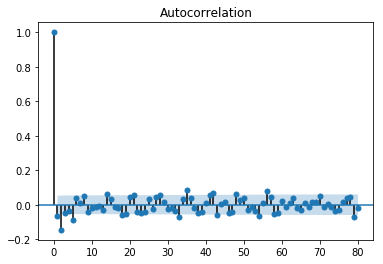

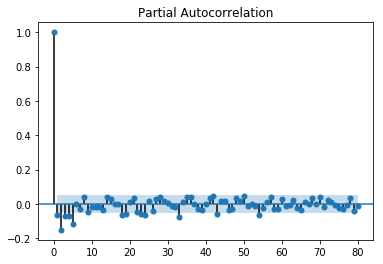


trend_blockchain_val 1398


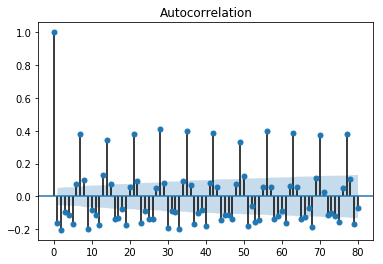

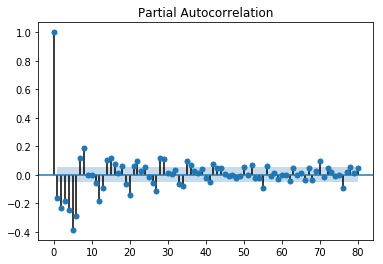

In [19]:
for f in df_returns.columns:
    print(f, len(df_returns.dropna()[f]))
    plot_acf(df_returns.dropna()[f], lags=80)
    plt.show() 

    plot_pacf(df_returns.dropna()[f], lags=80)
    plt.show()
    
    print("")



## BTC Regression

### Helper Functions

#### TS to ML format

In [20]:
def dataframe_ts_to_supervised(df, pred_vars, n_input=1, n_pred=1, dropnan=True, separate_xy=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        df: Sequence of observations as a list or NumPy array.
        pred_vars: columns for prediction (Y)
        n_in: Number of lag time steps as input (Xt, Xt-1, ..., Xt-n_in-1).
        n_out: Number of observations as output (yt+1, ..., yt+n_out).
        dropnan: Boolean whether or not to drop rows with NaN values.
        separate_xy: Boolean whether to return combined X+Y df or tuple X df, Y df
    Returns:
        Pandas DataFrame framed for supervised learning.
    """
    n_vars = df.shape[1]
    var_names = df.columns 
    n_pred_vars = len(pred_vars)
    cols, names = list(), list()
    
    # input sequence (t, ..., t-n)
    for i in range(0, n_input):
        cols.append(df.shift(i))
        if i == 0:
            names += [('{}(t)'.format(var_names[j], i)) for j in range(n_vars)]
        else:
            names += [('{}(t-{})'.format(var_names[j], i)) for j in range(n_vars)]
    # forecast sequence (t+1, ... t+n)
    for i in range(1, n_pred+1):
        cols.append(df[pred_vars].shift(-i))
        names += [('{}(t+{})'.format(pred_vars[j], i)) for j in range(n_pred_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    if separate_xy:
        return (agg.iloc[:,:-n_pred],agg.iloc[:,-n_pred:])
    else:
        return agg

#### Validation Loop

In [58]:
def do_data_science(model, X_in, Y_in, rand_state=42, folds = 5):
    '''
    Runs the model on the given data
    Input: 
        required: model, X (input), Y (target)
        optional: rand_state, folds (passes these through to kfolds)
    Output: prints model stats, shows diagnostic charts, returns fitted model
    '''
    ts_split = TimeSeriesSplit(n_splits=folds)

    model_rmse, model_mad, model_r2, model_train_r2 = [],[],[],[]
    
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(15,3)
    ax[0].set_title("Predict vs. Observed")
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("Observed")
    
    ax[1].set_title("Predict vs. Residuals")
    ax[1].set_xlabel("Predicted")
    ax[1].set_ylabel("Residuals")
    
    ax[2].set_title("Norm Dist vs. Residuals (Q-Q)")
    ax[2].set_xlabel("Norm Quantiles")
    ax[2].set_ylabel("Residual Quantiles")

    colors = ["b","g","r","c","m","y","k","w"]
    
    i = 0
    min_point = np.inf
    max_point = np.inf*(-1)
    
    X_arg,Y_arg = np.array(X_in),np.array(Y_in)

    for train_ind, test_ind in ts_split.split(X_arg,Y_arg):
    
        X_train = X_arg[train_ind]
        X_test = X_arg[test_ind]
        Y_train = Y_arg[train_ind]
        Y_test = Y_arg[test_ind]

        model.fit(X_train,Y_train)

        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        model_rmse.append(np.sqrt(np.mean((test_pred - Y_test)**2)))
        model_mad.append(np.mean(np.abs(test_pred - Y_test)))
        model_r2.append(model.score(X_test,Y_test))
        model_train_r2.append(model.score(X_train,Y_train))
        
        #Prediction vs actual
        min_point = min(min_point, max(np.min(Y_test),np.min(test_pred)))
        max_point = max(max_point, min(np.max(Y_test),np.max(test_pred)))
        ax[0].scatter(test_pred,Y_test, alpha=.1, c=colors[i%len(colors)])

        #Residuals
        ax[1].scatter(test_pred, Y_test-test_pred, alpha=.1, c=colors[i%len(colors)])
        #plt.show()
        
        #Q-Q plot
        (x_norm, y_resid), (slope,intercept,_) = stats.probplot(Y_test-test_pred, dist="norm")
        ax[2].scatter(x_norm,y_resid,alpha=.1,c=colors[i%len(colors)])
        ax[2].plot(x_norm, slope*x_norm+intercept)
        
        i+=1
            
    ax[0].plot([min_point,max_point],[min_point,max_point],c="k")
    plt.show()

    #R-square
    print("Test R2:     ", np.mean(model_r2),"std dev:",np.std(model_r2))
    print("Train R2:    ", np.mean(model_train_r2),"std dev:",np.std(model_train_r2))
    
    #RMSE
    print("RMSE:        ",np.mean(model_rmse),"std dev:",np.std(model_rmse))
    
    # Mean Absolute Deviation
    print("Mean Abs Dev:",np.mean(model_mad),"std dev:",np.std(model_mad))

    #values
    print("Test RMSE values:",[round(x,4) for x in model_rmse])
    #print("Mean Abs Dev values:",model_mad)
    print("Test R Square values:",[round(x,4) for x in model_r2])
    #print("Train R Square values:",model_train_r2)

    #model.fit(X_arg, Y_arg)
    return model

#### Baseline predictors

In [22]:
class PersistenceBaseline():
    '''
    Model which always predicts the previous value (t+1 = t)
    **Assumes the predicted variable is the first X column**
    '''
    def __init__(self):
        pass
    def fit(self,X,Y):
        pass
    def predict(self,X):
        return X[:,0]
    def score(self, X, Y):
        return r2_score(Y,self.predict(X))

class MeanBaseline():
    '''
    Model which always predicts the mean training set value
    **Assumes the predicted variable is the first X column**
    '''
    def __init__(self):
        pass
    def fit(self,X,Y):
        self.mean = np.mean(X[:,0])
    def predict(self,X):
        return [self.mean]*(X.shape[0])
    def score(self, X, Y):
        return r2_score(Y,self.predict(X))


### Predictions

#### Baseline

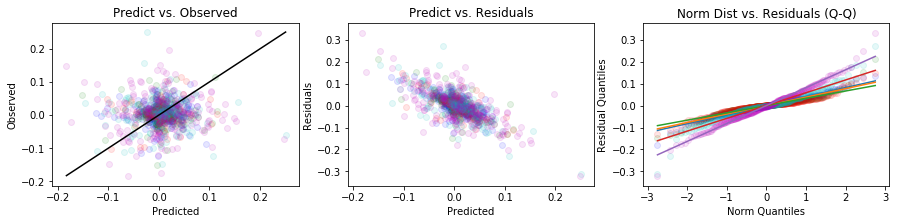

Test R2:      -0.9837669852623284 std dev: 0.0631371343582811
Train R2:     -0.9624419160463396 std dev: 0.014949470604714235
RMSE:         0.05163715385396354 std dev: 0.017363333561146783
Mean Abs Dev: 0.03641520137505378 std dev: 0.0142334753004503
Test RMSE values: [0.0414, 0.0404, 0.0344, 0.0604, 0.0816]
Test R Square values: [-1.0559, -1.0127, -0.9035, -1.0335, -0.9133]


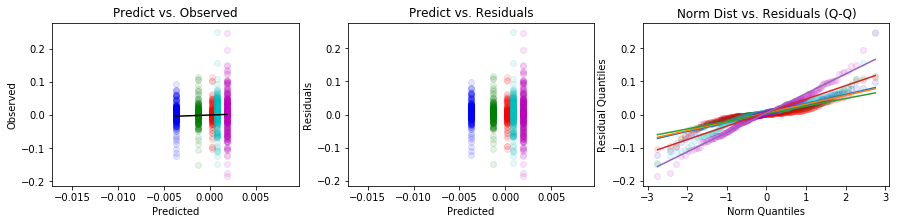

Test R2:      -0.01710823562140278 std dev: 0.008309925554478006
Train R2:     -4.2582667903356965e-06 std dev: 7.28337395140209e-06
RMSE:         0.03700971534740389 std dev: 0.012626845408969486
Mean Abs Dev: 0.02521276091713328 std dev: 0.010489951949309677
Test RMSE values: [0.0292, 0.0288, 0.025, 0.0427, 0.0592]
Test R Square values: [-0.0267, -0.0258, -0.0087, -0.0177, -0.0067]
0.0026987371228754586


In [57]:
X, Y = dataframe_ts_to_supervised(df_returns,["btc_price_close"])
Y = Y.iloc[:,0]

model = do_data_science(PersistenceBaseline(),X,Y)

model = do_data_science(MeanBaseline(),X,Y)
print (model.mean)

#### Linear Regression

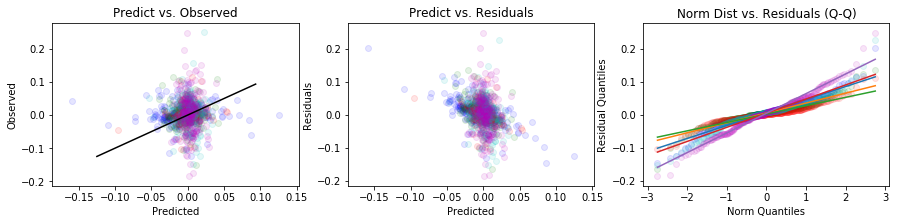

Test R2:      -0.3114436683714178 std dev: 0.3669130847156255
Train R2:     0.16060863351943258 std dev: 0.0985152764284418
RMSE:         0.04078646034375098 std dev: 0.011467003535857025
Mean Abs Dev: 0.028596656652000015 std dev: 0.009310489540488909
Test RMSE values: [0.0411, 0.032, 0.0266, 0.0443, 0.0599]
Test R Square values: [-1.0286, -0.2679, -0.1375, -0.092, -0.0312]


[('btc_price_close(t)', 0.0526428326755328),
 ('btc_fees(t)', -0.010012654784641173),
 ('btc_txcount(t)', 0.007678989007100269),
 ('btc_tx_unit(t)', 0.0011499620126298636),
 ('btc_ex_unit(t)', 0.00015146704203535975),
 ('ltc_price_close(t)', -0.022473670346672685),
 ('xrp_price_close(t)', -0.01902398235775278),
 ('xmr_price_close(t)', 0.012860554876283257),
 ('dash_price_close(t)', -0.002076414401281362),
 ('sp500_value(t)', 0.0948373621339112),
 ('gold_value(t)', -0.1621295603123536),
 ('liborusd_value(t)', 0.0961848096638842),
 ('trend_bitcoin_val(t)', 0.004878701773190431),
 ('trend_blockchain_val(t)', 4.381291335384639e-05),
 ('btc_price_close(t-1)', -0.04140366141961389),
 ('btc_fees(t-1)', -0.0035782371046378103),
 ('btc_txcount(t-1)', 0.0163897401842767),
 ('btc_tx_unit(t-1)', -0.0010979819808650817),
 ('btc_ex_unit(t-1)', -0.0010626415643374878),
 ('ltc_price_close(t-1)', 0.0017485310353976076),
 ('xrp_price_close(t-1)', 0.032974851100322604),
 ('xmr_price_close(t-1)', 0.012886

In [24]:
X, Y = dataframe_ts_to_supervised(df_returns,["btc_price_close"],n_input=5)
Y = Y.iloc[:,0]

model = do_data_science(LinearRegression(),X,Y)

list(zip(X.columns, model.coef_))

#### Random Forest

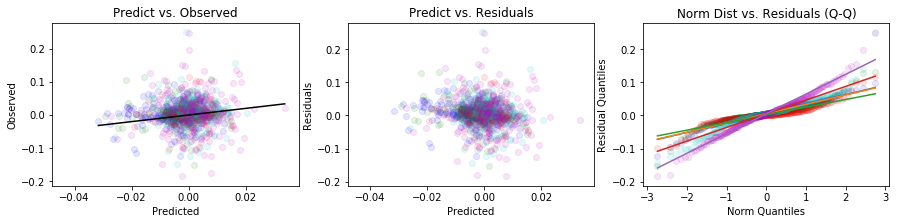

Test R2:      -0.04926112542004191 std dev: 0.042000853673625105
Train R2:     0.7274356854859322 std dev: 0.010421572650619047
RMSE:         0.037475880947372205 std dev: 0.012614573683717436
Mean Abs Dev: 0.02583424733845956 std dev: 0.010355657727633048
Test RMSE values: [0.0295, 0.0303, 0.0249, 0.0429, 0.0597]
Test R Square values: [-0.0753, -0.1199, -0.0123, -0.0189, -0.0199]


[('btc_price_close(t)', 0.03503164181610205),
 ('btc_fees(t)', 0.014298709142315609),
 ('btc_txcount(t)', 0.003953044074604239),
 ('btc_tx_unit(t)', 0.004140709942987676),
 ('btc_ex_unit(t)', 0.010351228847730749),
 ('ltc_price_close(t)', 0.0171031592135222),
 ('xrp_price_close(t)', 0.011646782211014912),
 ('xmr_price_close(t)', 0.007199713771766582),
 ('dash_price_close(t)', 0.014530077401899495),
 ('sp500_value(t)', 0.004598150277133834),
 ('gold_value(t)', 0.0046240200434919014),
 ('liborusd_value(t)', 0.0034492180411431514),
 ('trend_bitcoin_val(t)', 0.004765229760863652),
 ('trend_blockchain_val(t)', 0.00324607205935489),
 ('btc_price_close(t-1)', 0.014665597326978096),
 ('btc_fees(t-1)', 0.006157727128250623),
 ('btc_txcount(t-1)', 0.006193782820306419),
 ('btc_tx_unit(t-1)', 0.004445300323161486),
 ('btc_ex_unit(t-1)', 0.0048267325222261055),
 ('ltc_price_close(t-1)', 0.007311465899058503),
 ('xrp_price_close(t-1)', 0.016256841481242727),
 ('xmr_price_close(t-1)', 0.005353182671

In [25]:
X, Y = dataframe_ts_to_supervised(df_returns,["btc_price_close"],n_input=10)
Y = Y.iloc[:,0]

model = do_data_science(RandomForestRegressor(n_estimators=500, min_samples_leaf=3,n_jobs=-1),X,Y)

pprint.pprint(sorted(list(zip(X.columns, model.feature_importances_)),key=lambda x:x[1],reverse=True)[:20])

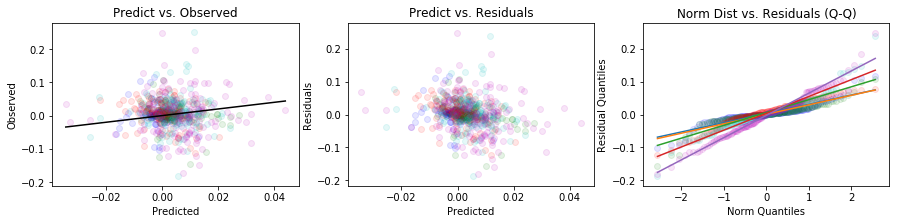

Test R2:      -0.07743423865498977 std dev: 0.05247037234828139
Train R2:     0.6818017974085439 std dev: 0.04349629124524016
RMSE:         0.04429890021528534 std dev: 0.013983850324478927
Mean Abs Dev: 0.03137098263462073 std dev: 0.012507991984687801
Test RMSE values: [0.0303, 0.0315, 0.0398, 0.0525, 0.0674]
Test R Square values: [-0.0509, -0.138, -0.1431, -0.0204, -0.0347]


[('btc_price_close(t)', 0.026527024454529806),
 ('btc_fees(t)', 0.006772972722026565),
 ('btc_txcount(t)', 0.004450475086500546),
 ('btc_tx_unit(t)', 0.002799510069236845),
 ('btc_ex_unit(t)', 0.005713212084750723),
 ('ltc_price_close(t)', 0.009410870779271307),
 ('xrp_price_close(t)', 0.012576050959324852),
 ('xmr_price_close(t)', 0.003725865017382931),
 ('dash_price_close(t)', 0.012348697211303755),
 ('sp500_value(t)', 0.004001141469889977),
 ('gold_value(t)', 0.00691159905417087),
 ('liborusd_value(t)', 0.004401149217659549),
 ('trend_bitcoin_val(t)', 0.0050727841160672195),
 ('trend_blockchain_val(t)', 0.0022691563319035095),
 ('btc_price_close(t-1)', 0.013713618516014095),
 ('btc_fees(t-1)', 0.005013371077610782),
 ('btc_txcount(t-1)', 0.0066714883817625935),
 ('btc_tx_unit(t-1)', 0.003962940155256159),
 ('btc_ex_unit(t-1)', 0.005004633056751291),
 ('ltc_price_close(t-1)', 0.0074543277688814275),
 ('xrp_price_close(t-1)', 0.019022356580028578),
 ('xmr_price_close(t-1)', 0.00715291

In [26]:
X, Y = dataframe_ts_to_supervised(df_returns["2016":],["btc_price_close"],n_input=10)
Y = Y.iloc[:,0]

model = do_data_science(RandomForestRegressor(n_estimators=500, min_samples_leaf=3,n_jobs=-1),X,Y)

pprint.pprint(sorted(list(zip(X.columns, model.feature_importances_)),key=lambda x:x[1],reverse=True)[:20])

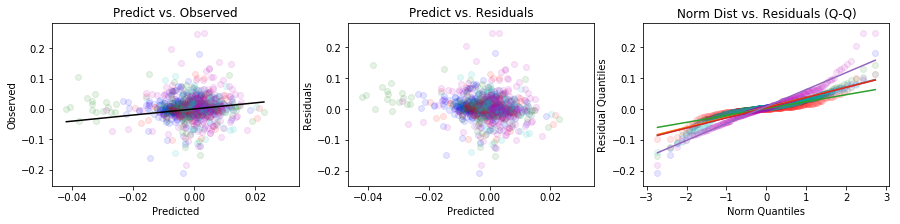

Test R2:      -0.05996192428173375 std dev: 0.06836882792014976
Train R2:     0.737282305779291 std dev: 0.009472332391059228
RMSE:         0.03720020528937269 std dev: 0.010544686958702247
Mean Abs Dev: 0.024633623963796186 std dev: 0.008427191420873382
Test RMSE values: [0.0359, 0.0344, 0.0245, 0.0345, 0.0567]
Test R Square values: [-0.0277, -0.1934, -0.0043, -0.0513, -0.0231]


[('btc_price_close(t)', 0.039395332561093045),
 ('btc_fees(t)', 0.014649373896205688),
 ('btc_txcount(t)', 0.0039634318172229325),
 ('btc_tx_unit(t)', 0.004047742465676153),
 ('btc_ex_unit(t)', 0.012041017991741797),
 ('ltc_price_close(t)', 0.014288413073387648),
 ('xrp_price_close(t)', 0.01510248817008421),
 ('xmr_price_close(t)', 0.010988961007369248),
 ('dash_price_close(t)', 0.012417582181493369),
 ('sp500_value(t)', 0.003656794250346825),
 ('gold_value(t)', 0.004191339671790395),
 ('liborusd_value(t)', 0.0033898626836029126),
 ('trend_bitcoin_val(t)', 0.004631286960398768),
 ('trend_blockchain_val(t)', 0.002988410188136123),
 ('btc_price_close(t-1)', 0.014777749161672717),
 ('btc_fees(t-1)', 0.0062532116118085785),
 ('btc_txcount(t-1)', 0.0076707846765649),
 ('btc_tx_unit(t-1)', 0.004240925769831322),
 ('btc_ex_unit(t-1)', 0.005979085966431059),
 ('ltc_price_close(t-1)', 0.00647985637819899),
 ('xrp_price_close(t-1)', 0.012629179737254585),
 ('xmr_price_close(t-1)', 0.004711909811

In [27]:
X, Y = dataframe_ts_to_supervised(df_returns[:"2017"],["btc_price_close"],n_input=10)
Y = Y.iloc[:,0]

model = do_data_science(RandomForestRegressor(n_estimators=500, min_samples_leaf=3,n_jobs=-1),X,Y)

pprint.pprint(sorted(list(zip(X.columns, model.feature_importances_)),key=lambda x:x[1],reverse=True)[:20])

#### XGBoost

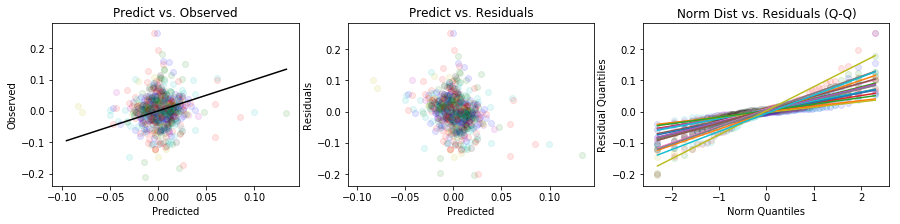

Test R2:      -0.3065546267668035 std dev: 0.4637080124431952
Train R2:     0.9458163517719355 std dev: 0.0495238033046469
RMSE:         0.038897226486951944 std dev: 0.014413544078937097
Mean Abs Dev: 0.02771391876597184 std dev: 0.011057262192903683
Test RMSE values: [0.0378, 0.0542, 0.0389, 0.024, 0.0277, 0.0319, 0.0413, 0.0379, 0.0173, 0.0308, 0.0317, 0.0195, 0.0214, 0.0401, 0.0378, 0.0426, 0.055, 0.0546, 0.0762, 0.0572]
Test R Square values: [0.0045, -0.1286, -0.094, -0.5196, -0.7928, -0.6254, -0.1685, -0.235, -0.8462, 0.0267, -0.143, -1.9901, -0.1568, -0.0937, -0.1494, -0.1012, 0.0074, -0.0511, -0.1157, 0.0414]


[('btc_price_close(t)', 0.03476152),
 ('btc_fees(t)', 0.02829426),
 ('trend_bitcoin_val(t-16)', 0.011317704),
 ('btc_ex_unit(t)', 0.010509296),
 ('btc_txcount(t-23)', 0.010509296),
 ('trend_bitcoin_val(t-38)', 0.00970089),
 ('xrp_price_close(t)', 0.008892482),
 ('btc_price_close(t-1)', 0.008892482),
 ('dash_price_close(t)', 0.008084075),
 ('xrp_price_close(t-1)', 0.008084075),
 ('trend_bitcoin_val(t-1)', 0.008084075),
 ('ltc_price_close(t-24)', 0.008084075),
 ('btc_txcount(t)', 0.007275667),
 ('trend_bitcoin_val(t-3)', 0.007275667),
 ('btc_price_close(t-5)', 0.007275667),
 ('btc_fees(t-17)', 0.007275667),
 ('sp500_value(t-20)', 0.007275667),
 ('liborusd_value(t-25)', 0.007275667),
 ('trend_bitcoin_val(t-25)', 0.007275667),
 ('ltc_price_close(t-32)', 0.007275667),
 ('trend_bitcoin_val(t-37)', 0.007275667),
 ('dash_price_close(t-1)', 0.0064672595),
 ('dash_price_close(t-2)', 0.0064672595),
 ('btc_fees(t-4)', 0.0064672595),
 ('ltc_price_close(t-6)', 0.0064672595),
 ('trend_bitcoin_val(t-1

In [28]:
X, Y = dataframe_ts_to_supervised(df_returns,["btc_price_close"],n_input=20)
Y = Y.iloc[:,0]

model = do_data_science(xgb.XGBRegressor(n_estimators = 200, n_jobs=-1),X,Y,folds=20)

pprint.pprint(sorted(list(zip(X.columns, model.feature_importances_)),key=lambda x:x[1],reverse=True)[:20])

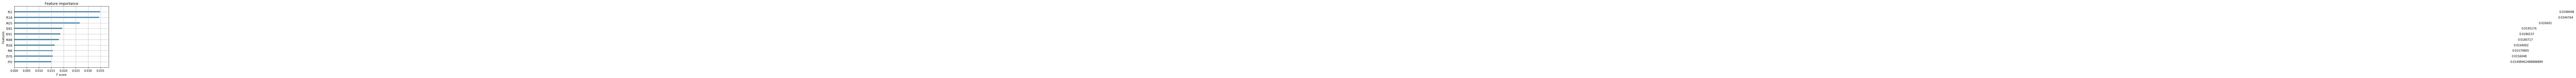

In [29]:
#xgb.plot_importance(model, importance_type="weight")

xgb.plot_importance(model, importance_type="gain", max_num_features=10)



#### LSTM

In [51]:
class LSTM_wrapper():
    '''
    Wrapper for Keras LSTM to be useable in my validation function
    '''
    def __init__(self, epochs=50, batch_size=32, validation_split=.1, nodes=50):
        self.scaler = MinMaxScaler()
        self.epochs = epochs
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.nodes = nodes
        
    def fit(self,X,Y,epochs = 50, batch_size=32):
        X = self.scaler.fit_transform(X)
        X = X.reshape(X.shape[0],1,X.shape[1])
        
        mod = Sequential()
        mod.add(LSTM(self.nodes, input_shape=(X.shape[1], X.shape[2])))
        mod.add(Dropout(.2))
        mod.add(Dense(1))
        mod.compile(loss='mse', optimizer='adam')
        
        self.history = mod.fit(X,Y,epochs=self.epochs,batch_size=self.batch_size,shuffle=False,
                               validation_split=self.validation_split,verbose=0)
        self.model = mod
        
    def predict(self,X):
        X = self.scaler.transform(X)
        X = X.reshape(X.shape[0],1,X.shape[1])

        result = self.model.predict(X)
        return result.reshape(result.shape[0])
    
    def score(self, X, Y):
        return r2_score(Y,self.predict(X))

In [ ]:
for b in [10,30,50,80,120]:
    print("\nt-{} features\n".format(i))

    for f in features_sets:
        print("\n",f,"\n")
        X, Y = dataframe_ts_to_supervised(df_returns[f],["btc_price_close"],n_input=1)
        Y = Y.iloc[:,0]

        model = do_data_science(LSTM_wrapper(epochs=30, batch_size=b,validation_split=0),X,Y)

        pprint.pprint(sorted(list(zip(X.columns, model.feature_importances_)),key=lambda x:x[1],reverse=True)[:10])


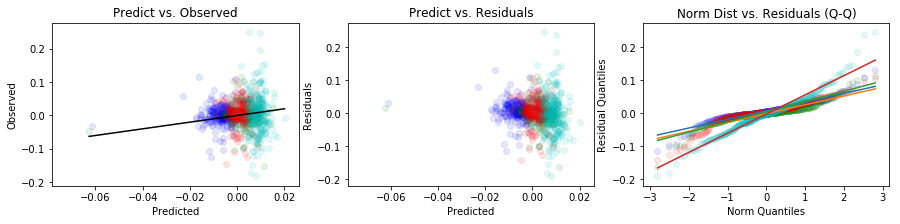

Test R2:      -0.039871169882623125 std dev: 0.028035559062158103
Train R2:     0.015428117397211921 std dev: 0.022796003028540044
RMSE:         0.037136862278691285 std dev: 0.012593499742742173
Mean Abs Dev: 0.025338908517364422 std dev: 0.010200706248916834
Test RMSE values: [0.0283, 0.0287, 0.0328, 0.0587]
Test R Square values: [-0.085, -0.0338, -0.0328, -0.0079]


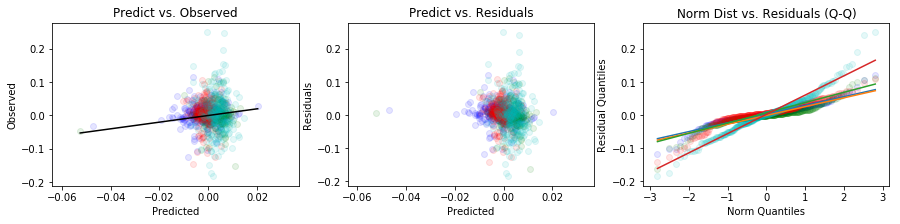

Test R2:      -0.027919353343834663 std dev: 0.01788680271851229
Train R2:     0.02565575700035569 std dev: 0.011969521513999505
RMSE:         0.036997078538058725 std dev: 0.012752378833162424
Mean Abs Dev: 0.025308689024047284 std dev: 0.010281310924404988
Test RMSE values: [0.0275, 0.0285, 0.0332, 0.0588]
Test R Square values: [-0.0241, -0.0212, -0.0573, -0.009]


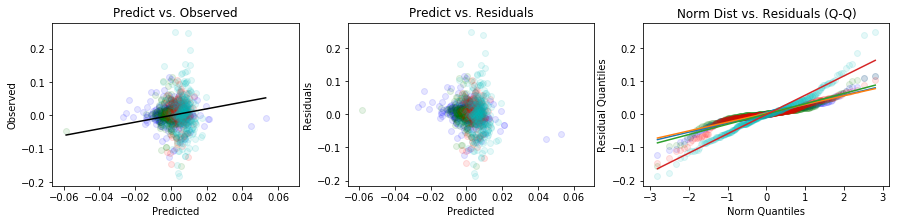

Test R2:      -0.042772944519096856 std dev: 0.04883487104398208
Train R2:     -0.0035148722571345936 std dev: 0.020867493747123964
RMSE:         0.037156920247594614 std dev: 0.012562102172902151
Mean Abs Dev: 0.02532388892743216 std dev: 0.010154512577055096
Test RMSE values: [0.0288, 0.0286, 0.0324, 0.0588]
Test R Square values: [-0.1259, -0.0299, -0.0065, -0.0088]


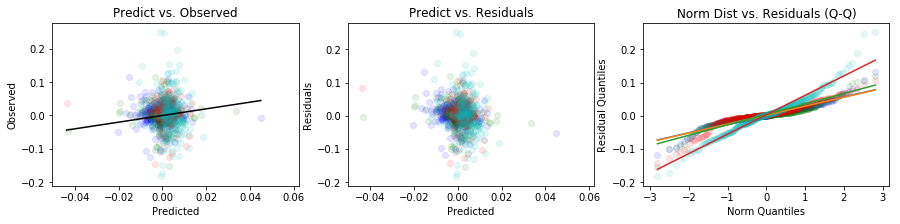

Test R2:      -0.042470589837938055 std dev: 0.01774538502661722
Train R2:     0.01309098629979491 std dev: 0.007680117270849372
RMSE:         0.037226639802064074 std dev: 0.01274987571953002
Mean Abs Dev: 0.025413479144516297 std dev: 0.010289329294003832
Test RMSE values: [0.028, 0.0287, 0.0331, 0.0591]
Test R Square values: [-0.067, -0.0347, -0.0493, -0.019]


In [63]:
for b in [16,32,64,96]:
    model = do_data_science(LSTM_wrapper(epochs=30, batch_size=b,validation_split=0),X,Y,folds=5)

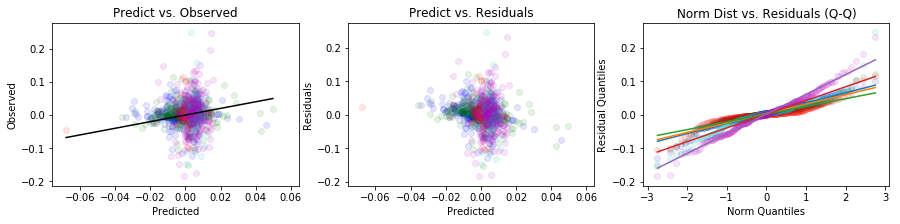

Test R2:      -0.06466819170141833 std dev: 0.07388447043301948
Train R2:     -0.02999552404991952 std dev: 0.041724142942522885
RMSE:         0.037618967411865004 std dev: 0.012095384928583785
Mean Abs Dev: 0.025927731495276087 std dev: 0.010110674545043951
Test RMSE values: [0.0315, 0.0299, 0.0252, 0.0426, 0.059]
Test R Square values: [-0.1907, -0.1067, -0.0193, -0.0089, 0.0023]


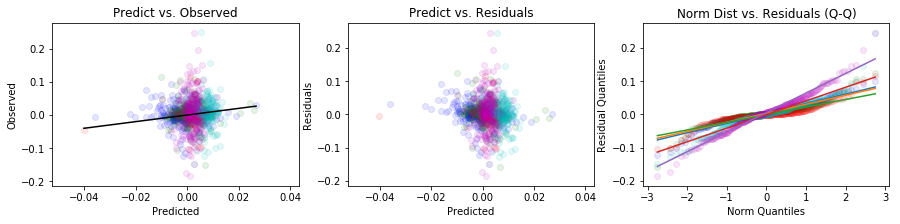

Test R2:      -0.02718130916069945 std dev: 0.03137779046624799
Train R2:     0.0075326906995800465 std dev: 0.018954907079095674
RMSE:         0.03713349461823619 std dev: 0.01248340598197909
Mean Abs Dev: 0.02525586640803592 std dev: 0.010422669444259491
Test RMSE values: [0.0299, 0.0292, 0.0249, 0.0425, 0.0591]
Test R Square values: [-0.0733, -0.056, 0.0051, -0.0073, -0.0043]


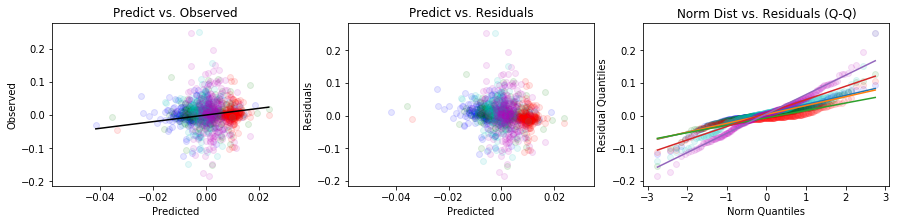

Test R2:      -0.044225790152085054 std dev: 0.013797723456692921
Train R2:     -0.009019088945538578 std dev: 0.03170407602802596
RMSE:         0.03745545857571738 std dev: 0.012642164341261572
Mean Abs Dev: 0.026082097259146397 std dev: 0.0102284592283515
Test RMSE values: [0.0295, 0.029, 0.0257, 0.0433, 0.0597]
Test R Square values: [-0.0477, -0.0409, -0.0644, -0.0466, -0.0215]


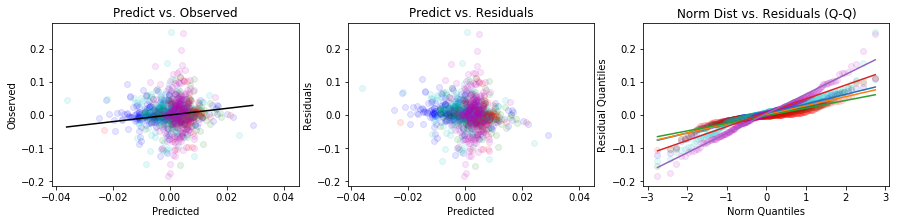

Test R2:      -0.0375921281920097 std dev: 0.033439482448628814
Train R2:     -0.007841916568373875 std dev: 0.026279557172125555
RMSE:         0.0373559324299099 std dev: 0.012611189656067301
Mean Abs Dev: 0.025725442191692226 std dev: 0.01042996720684377
Test RMSE values: [0.0301, 0.0289, 0.0249, 0.0436, 0.0592]
Test R Square values: [-0.0893, -0.0328, 0.0003, -0.0597, -0.0064]


In [62]:
for n in [10,20,40,50]:
    model = do_data_science(LSTM_wrapper(epochs=60-n, nodes=n),X,Y,folds=5)

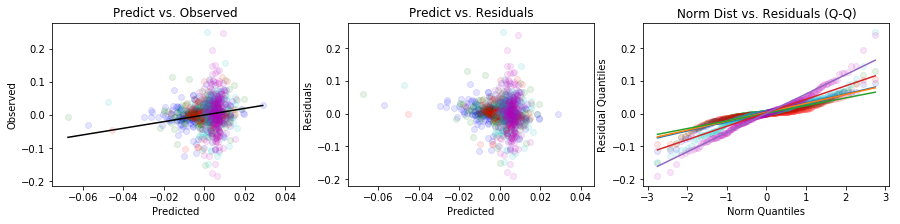

Test R2:      -0.01534966162379694 std dev: 0.0188872762245143
Train R2:     -0.02207888100594375 std dev: 0.0244574138020358
RMSE:         0.0369659266452238 std dev: 0.012565225174173638
Mean Abs Dev: 0.02541266822579748 std dev: 0.010213686625031136
Test RMSE values: [0.0291, 0.0291, 0.0248, 0.0427, 0.059]
Test R Square values: [-0.0184, -0.0486, 0.0058, -0.0151, -0.0004]


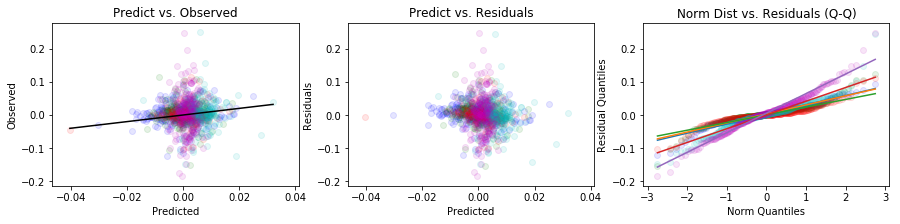

Test R2:      -0.02050825946574313 std dev: 0.018164181022315384
Train R2:     -0.010068361831239136 std dev: 0.02839128094520345
RMSE:         0.0370752534246816 std dev: 0.012661097818709211
Mean Abs Dev: 0.02545347837603449 std dev: 0.010411589837546005
Test RMSE values: [0.0291, 0.0292, 0.0249, 0.0428, 0.0593]
Test R Square values: [-0.0159, -0.0545, -0.001, -0.0203, -0.0108]


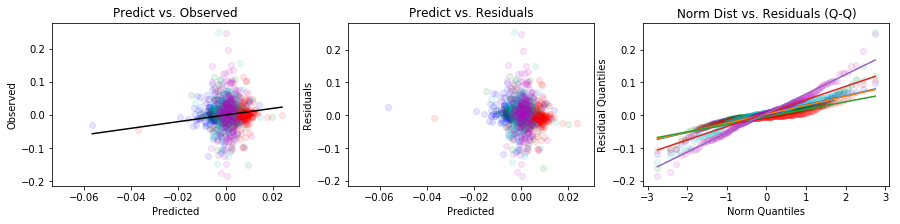

Test R2:      -0.02612095017093625 std dev: 0.0195568997035123
Train R2:     0.014109330770641004 std dev: 0.02242452563015326
RMSE:         0.03716782753114452 std dev: 0.012676371750695843
Mean Abs Dev: 0.025593482397633475 std dev: 0.010437098328253685
Test RMSE values: [0.029, 0.0294, 0.0251, 0.0429, 0.0595]
Test R Square values: [-0.0096, -0.0643, -0.0175, -0.0232, -0.0161]


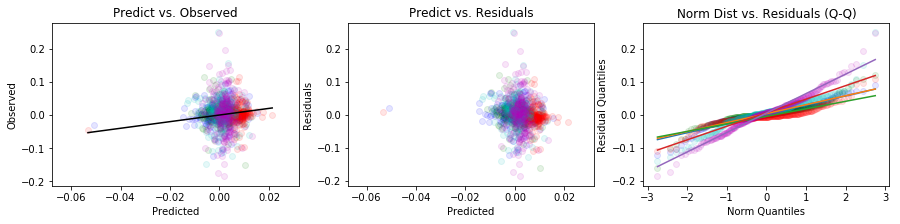

Test R2:      -0.02697820026653632 std dev: 0.019963641099179058
Train R2:     0.011129603570784852 std dev: 0.022187582822455414
RMSE:         0.03718476014339467 std dev: 0.012683604256398638
Mean Abs Dev: 0.02560737106732345 std dev: 0.010385749667885429
Test RMSE values: [0.0288, 0.0293, 0.0253, 0.0431, 0.0595]
Test R Square values: [0.0018, -0.0579, -0.0306, -0.0336, -0.0146]


In [64]:
for n in [10,30,50,70]:
    model = do_data_science(LSTM_wrapper(epochs=30, nodes=n),X,Y,folds=5)

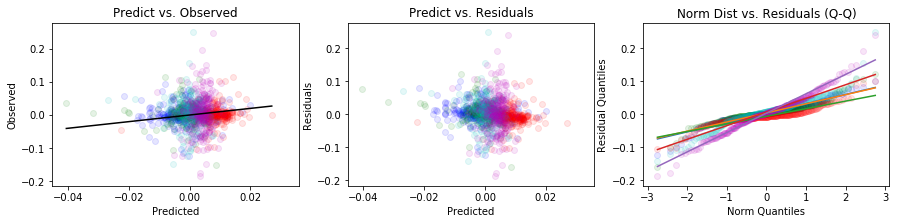

Test R2:      -0.044264408638588625 std dev: 0.028839119134116995
Train R2:     -0.008977979700988459 std dev: 0.028999189547441077
RMSE:         0.03739176385826798 std dev: 0.012380941172944426
Mean Abs Dev: 0.025913744026873336 std dev: 0.010067751745996504
Test RMSE values: [0.0294, 0.0297, 0.0255, 0.0433, 0.059]
Test R Square values: [-0.0412, -0.0902, -0.0446, -0.0461, 0.0008]


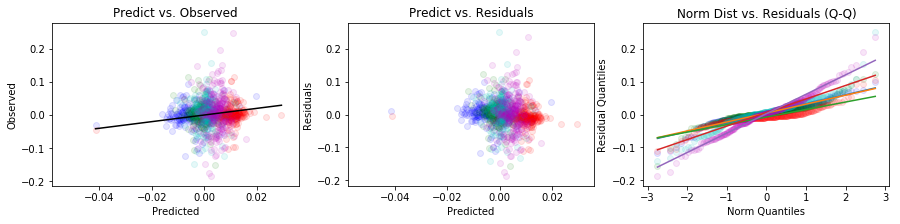

Test R2:      -0.03800184358579961 std dev: 0.03084212723367509
Train R2:     -0.006423750946107143 std dev: 0.0362368334910082
RMSE:         0.03727824993653493 std dev: 0.012398307862047066
Mean Abs Dev: 0.02589158808800875 std dev: 0.010002589721046819
Test RMSE values: [0.029, 0.0293, 0.026, 0.0431, 0.0591]
Test R Square values: [-0.0111, -0.0593, -0.0853, -0.0327, -0.0017]


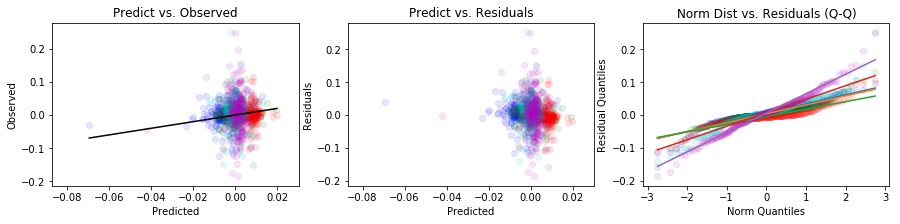

Test R2:      -0.03663800946161468 std dev: 0.014644815178419274
Train R2:     0.007369359128070374 std dev: 0.024335337199557584
RMSE:         0.03732631232855648 std dev: 0.012613364633149689
Mean Abs Dev: 0.025758786148507646 std dev: 0.010365197641844404
Test RMSE values: [0.0293, 0.0293, 0.0254, 0.0432, 0.0595]
Test R Square values: [-0.0308, -0.0607, -0.039, -0.0373, -0.0154]


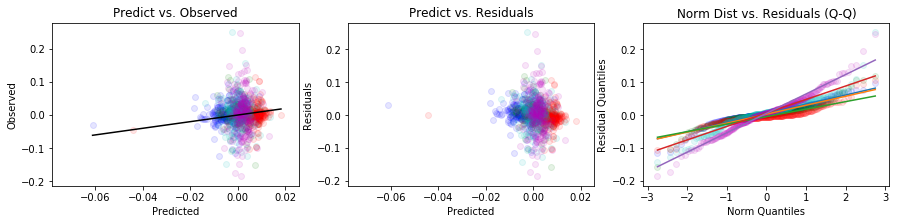

Test R2:      -0.03053555820812819 std dev: 0.013427438367327073
Train R2:     0.012283993361719103 std dev: 0.02034618520489302
RMSE:         0.03723626697882846 std dev: 0.012640181090271341
Mean Abs Dev: 0.025647712410741368 std dev: 0.010385932914728871
Test RMSE values: [0.0293, 0.0292, 0.0252, 0.0431, 0.0594]
Test R Square values: [-0.0323, -0.053, -0.0206, -0.0332, -0.0135]


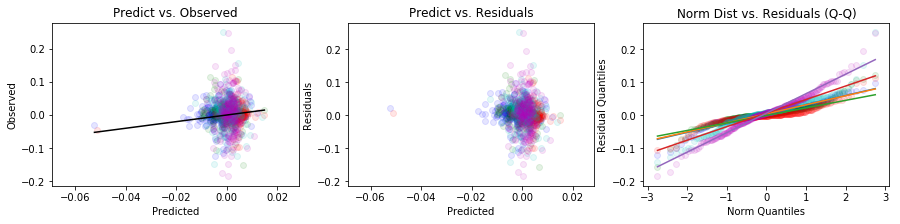

Test R2:      -0.024215723924719913 std dev: 0.02802409825194275
Train R2:     0.02256936908766318 std dev: 0.010844379583471377
RMSE:         0.037157661126265576 std dev: 0.012728544326646407
Mean Abs Dev: 0.02546393781583937 std dev: 0.01060525817064858
Test RMSE values: [0.029, 0.0295, 0.0248, 0.043, 0.0595]
Test R Square values: [-0.0122, -0.0735, 0.0108, -0.0312, -0.015]


In [61]:
for e in [10,20,30,40,50]:
    model = do_data_science(LSTM_wrapper(epochs=e),X,Y,folds=5)


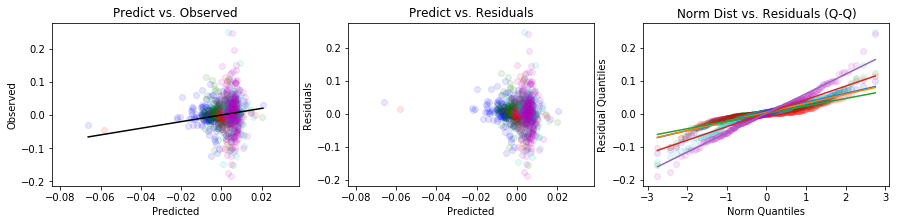

Test R2:      -0.022674514450991758 std dev: 0.029672796312671036
Train R2:     0.02282527337825957 std dev: 0.018861647049838153
RMSE:         0.03706816171115174 std dev: 0.012514749329055894
Mean Abs Dev: 0.025244765596336354 std dev: 0.01033656175296528
Test RMSE values: [0.0294, 0.0295, 0.0248, 0.0425, 0.0591]
Test R Square values: [-0.0367, -0.0741, 0.0084, -0.0074, -0.0036]


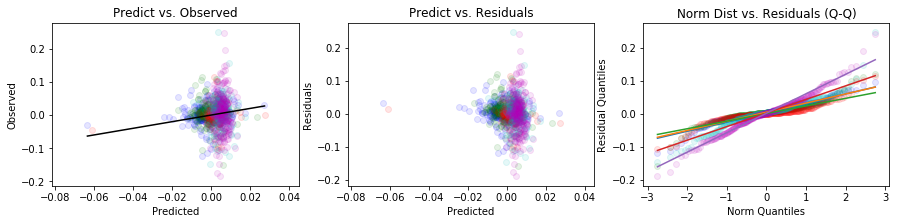

Test R2:      -0.02571196689193205 std dev: 0.032965828070523485
Train R2:     0.04115081772342002 std dev: 0.030052762438498724
RMSE:         0.03710676139942772 std dev: 0.012470703269647655
Mean Abs Dev: 0.025322593233905427 std dev: 0.010313183008207853
Test RMSE values: [0.0292, 0.0297, 0.0249, 0.0427, 0.059]
Test R Square values: [-0.0259, -0.0887, 0.0007, -0.0142, -0.0004]


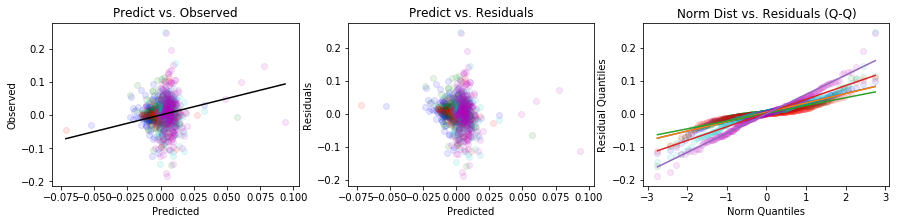

Test R2:      -0.04715623049693847 std dev: 0.04908082824569057
Train R2:     0.11619780283701657 std dev: 0.05277080669920775
RMSE:         0.037386562905786735 std dev: 0.012207229063716905
Mean Abs Dev: 0.025676617829015223 std dev: 0.00999028498283785
Test RMSE values: [0.0296, 0.0303, 0.0252, 0.0431, 0.0587]
Test R Square values: [-0.0525, -0.1364, -0.0244, -0.0332, 0.0107]


In [67]:
for e in [100,200,400]:
    model = do_data_science(LSTM_wrapper(epochs=e),X,Y,folds=5)


In [36]:
model = LSTM_wrapper()

X, Y = dataframe_ts_to_supervised(df_returns,["btc_price_close"],n_input=20)
Y = Y.iloc[:,0]

model.fit(X,Y)

model.predict(X)

array([[ 0.02382787],
       [ 0.03985114],
       [ 0.00410109],
       ...,
       [ 0.02165228],
       [-0.00526092],
       [-0.00488887]], dtype=float32)

In [ ]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)